# Mood and weather correlation

In [1]:
# installing libraries
!pip install python_weather
!pip install tweepy
!pip install stop_words
!pip install pymysql
!pip install googletrans==4.0.0rc1
!pip install transformers
!pip install geopy

In [2]:
# importing required libraries
import re
import tweepy
from tweepy import OAuthHandler
import json
import pandas as pd
import datetime
import pymysql
import googletrans
from os.path import exists
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="tutorial")
import seaborn as sns

#This is how to get the lastest model uncomment the lines and run it once it will be saved then comment those 5 lines and pull the model from local path
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# model.save_pretrained('C:/Users/Dell/Downloads/sentimodels')
# tokenizer.save_pretrained('C:/Users/Dell/Downloads/sentimodels')
tokenizer = AutoTokenizer.from_pretrained('C:/Users/Dell/Downloads/sentimodels') # path of your model folder
model = AutoModelForSequenceClassification.from_pretrained('C:/Users/Dell/Downloads/sentimodels') # path of the model folder
translator = googletrans.Translator()
from stop_words import get_stop_words
import json
import sys
import random
import requests

consumer_key = "hed40uwwO3yBYozPwJ6TIZDJD"
consumer_secret = "govduaChw5C5z05GLzZHCNkJImvyRvjJ1DImKty7ygYNEnndkp"
bearertoken = "AAAAAAAAAAAAAAAAAAAAAOfYYgEAAAAAaCY0M6qX9qgapv0Bk%2BvUvC9RDdE%3DbaEvNrXnooc2FQGjtso9qFwUS0YPKXQwiQUz0JvxwREvpA79Bn"
access_token ="792344353024856068-jLbPMxdgTQ9jeHonhbE6nqbp7uvYNQ8"
access_token_secret = "W70yP0eM5mKy9pBL4cYZAa7U8Mfd17PuJ86eI1sO7AUZC"

## Data Collection

- ### I am using twitter API to pull data from twitter and I am pulling data for 2 different cities i.e San Jose and Bangalore.
- ### After fetching the data I am finding the sentimental analysis for the tweets.
- ### I am also fetching the data from weatherapi.com to get the weather details when the tweets are accessed

In [46]:
class TwitterClient(object):
    '''
    Generic Twitter Class for sentiment analysis.
    '''
    def __init__(self):
        '''
        Class constructor or initialization method.
        '''
        
        consumer_key = 'obGL1uQZDwNxnQyYTS9aAVd5U'
        consumer_secret = 'sAyXjfH8qJqJhY4nDGjdECGjW2wwGZ8l0ImNoR8zfujnsovPCK'
        access_token = '792344353024856068-lTO3232dnRwiXMNMnKgRmtTlWxsv3tD'
        access_token_secret = 'ScaWnMTL5BWO07K7BuZtKHOSaIKYY9V8zsjZMt67n1fIS'


        # attempt authentication
        try:
            # create OAuthHandler object
            self.auth = OAuthHandler(consumer_key, consumer_secret)
            # set access token and secret
            self.auth.set_access_token(access_token, access_token_secret)
            # create tweepy API object to fetch tweets
            self.api = tweepy.API(self.auth)
        except:
            print("Error: Authentication Failed")
#     def get_tweets(self,until, geocode,count = 10,tweet_mode='extended'):
#         '''
#         Main function to fetch tweets and parse them.
#         '''
#         # empty list to store parsed tweets
#         tweets = []

#         try:
#             # call twitter api to fetch tweets
#             fetched_tweets = self.api.search_tweets(q = "-filter:retweets", until=until,count = count,tweet_mode=tweet_mode,geocode=geocode)
#             return fetched_tweets

#         except Exception as e: #tweepy.TweepError instead of Exception but getting error
#             # print error (if any)
#             print("Error : " + str(e))
    def clean_tweet(self, tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())


    def get_tweet_sentiment(self, tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using roberto huggingface's sentiment method
        It returns label and the probability of the all the labels
        '''

        #huggingface

        labels=['negative', 'neutral', 'positive']
        encoded_input = tokenizer(self.clean_tweet(tweet), return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        ranking = np.argsort(scores)
        ranking = ranking[::-1]
        return labels[ranking[0]],scores[0],scores[1],scores[2]

    def get_tweets(self, geocode,count = 10,tweet_mode='extended'):
        '''
        Main function to fetch tweets and parse them.
        '''
        # empty list to store parsed tweets
        tweets = []

        try:
            # call twitter api to fetch tweets
            fetched_tweets = self.api.search_tweets(q = "-filter:retweets",count = count,tweet_mode=tweet_mode,geocode=geocode)

            # parsing tweets one by one
            for tweet in fetched_tweets:
                # empty dictionary to store required params of a tweet
                parsed_tweet = {} #{id:1223,text:tweet}

                #adding tweet id
                parsed_tweet['tweet_id'] = tweet.id_str

                # saving text of tweet and translating to english
                if(hasattr(tweet,'retweeted_status')): #if retweet
                    try:
                        if(tweet.lang!='und'):
                            translation = translator.translate(tweet.retweeted_status.full_text, src=tweet.lang,dest='en') #translate to english
                            parsed_tweet['text'] = translation.text
                        else:
                            parsed_tweet['text'] = tweet.retweeted_status.full_text

                    except:
                        parsed_tweet['text'] = tweet.retweeted_status.full_text
                else: #if not retweet
                    try: 
                        if(tweet.lang!='und'):
                            translation = translator.translate(tweet.full_text,src=tweet.lang, dest='en') #translate to english
                            parsed_tweet['text'] = translation.text
                        else:
                            parsed_tweet['text'] = tweet.full_text
                    except:
                        parsed_tweet['text'] = tweet.full_text

                # saving sentiment of tweet
                parsed_tweet['sentiment'], parsed_tweet['neg_prob'], parsed_tweet['neu_prob'], parsed_tweet['pos_prob'] = self.get_tweet_sentiment(parsed_tweet['text'])

                #date of the tweet
                parsed_tweet['created_at'] = str(tweet.created_at).split('+')[0]	

                #add hashtags of retweets and non-retweets			
                hashtags=[]
                if(hasattr(tweet,'retweeted_status')):
                    for i in tweet.retweeted_status.entities['hashtags']:

                        hashtags.append(i['text'])

                    parsed_tweet['hashtags'] = ", ".join(hashtags)
                else:
                    for i in tweet.entities['hashtags']:

                        hashtags.append(i['text'])

                    parsed_tweet['hashtags'] = ", ".join(hashtags)

                #adding user name
                parsed_tweet['username'] = tweet.user.name

                #adding location of tweet
                parsed_tweet['location'] = str(tweet.user.location)

                #adding if it was retweet or not
                # if(hasattr(tweet,'retweeted_status')):
                # 	parsed_tweet['retweet']='yes'
                # else:
                # 	parsed_tweet['retweet']='no'

                #adding retweet count
                parsed_tweet['retweet_count'] = tweet.retweet_count

                #adding tweet in original language
                if(hasattr(tweet,'retweeted_status')):
                        parsed_tweet['orgtext'] = tweet.retweeted_status.full_text
                else:
                        parsed_tweet['orgtext'] = tweet.full_text


                #adding language of the tweet
                parsed_tweet['org_lang']=tweet.lang

                #adding favorite count
                parsed_tweet['favorite_count'] = tweet.favorite_count

                #location coordinates
                try:
                    location = geolocator.geocode(tweet.user.location)
                    #print(location.address)
                    #Flatiron Building, 175, 5th Avenue, Flatiron, New York, NYC, New York, ...
                    #print((location.latitude, location.longitude))
                    #(40.7410861, -73.9896297241625)
                    parsed_tweet['latitude']=location.latitude
                    parsed_tweet['longitude']=location.longitude
                except:
                    parsed_tweet['latitude']=None
                    parsed_tweet['longitude']=None

                #adding sentence after removing stopwords for creating word cloud in mstr
                words = self.clean_tweet(parsed_tweet['text']).lower().split(" ")
                filtered_words = [word for word in words if word not in get_stop_words('english')]
                parsed_tweet['cleaned_tweet'] = " ".join(filtered_words)

                if(hasattr(tweet,'retweeted_status') == False): #for not adding retweets, remove this if you want retweets as well
                    tweets.append(parsed_tweet)
            return tweets

        except Exception as e: #tweepy.TweepError instead of Exception but getting error
            # print error (if any)
            print("Error : " + str(e))

In [51]:
def main():
    global timeInSanJose
    global timeInBangalore 
    # creating object of TwitterClient Class
    api = TwitterClient()
    today = datetime.datetime.now().strftime("%Y-%m-%d") # current date


    # calling function to get tweets
    search_words='place:"San Jose, CA"' # if you want multiple search_words then use like this "climate+change"

    tweets = api.get_tweets(geocode = '37.279518,-121.867905,10mi', count = 100, tweet_mode='extended') # you can add language eg. lang='en' and until when you want the tweets
    print(tweets)
#     from datetime import datetime
    import pytz
    #getting current time for san jose
    SanJoseTz = pytz.timezone("America/Los_Angeles") 
    timeInSanJose = datetime.datetime.now(SanJoseTz)
    currentTimeInSanJose = timeInSanJose.strftime("%H:%M:%S")

    print("The current time in San Jose is:", currentTimeInSanJose)
    try:
    # Connecting to the database 
    connection = pymysql.connect(host='localhost',
                                 user='root', 
                                 password='root',
                                 db='tweets')

        cursor=connection.cursor()

        # insert the tweets into the database
        sql = "INSERT INTO tweets_sanjose (tweet_id,tweet,sentiment,created_at,hashtags,username,location,retweet_count,org_tweet,org_lang,favorite_count,latitude,longitude,cleaned_tweet,currenttime,positive_prob,negative_prob,neutral_prob) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,%s,%s,%s,%s,%s,%s,%s)"
        for tweet in tweets:
            try:
                cursor.execute(sql, (tweet['tweet_id'],tweet['text'],tweet['sentiment'],datetime.datetime.strptime(tweet['created_at'], '%Y-%m-%d %H:%M:%S'),tweet['hashtags'],tweet['username'],tweet['location'],tweet['retweet_count'],tweet['orgtext'],tweet['org_lang'],tweet['favorite_count'],tweet['latitude'],tweet['longitude'],tweet['cleaned_tweet'],timeInSanJose,tweet['pos_prob'],tweet['neg_prob'],tweet['neu_prob']))
            except OSError as e:
                            print(e)
            except:         
                print("Unexpected error:", sys.exc_info()[0])
        connection.commit()

    except OSError as e:
        print(e)
    except:         
        print("Unexpected error:", sys.exc_info()[0])
    finally:
        # close the database connection using close() method.
        connection.close()
    
    ## Tweets from bangalore
    tweets = api.get_tweets(geocode = '12.840711,77.676369,90km', count = 100, tweet_mode='extended') # you can add language eg. lang='en' and until when you want the tweets
    print(tweets)

    import pytz
    #getting current time of bangalore
    BangaloreTz = pytz.timezone("Asia/Kolkata") 
    timeInBangalore = datetime.datetime.now(BangaloreTz)
    currentTimeInBangalore = timeInBangalore.strftime("%H:%M:%S")

    print("The current time in Bangalore is:", currentTimeInBangalore)
    
    try:
    # Connecting to the database 
        connection = pymysql.connect(host='localhost',
                                 user='root', 
                                 password='root',
                                 db='tweets')

        cursor=connection.cursor()

        # insert the tweets into the database
        sql = "INSERT INTO tweets_bangalore (tweet_id,tweet,sentiment,created_at,hashtags,username,location,retweet_count,org_tweet,org_lang,favorite_count,latitude,longitude,cleaned_tweet,currenttime) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,%s,%s,%s,%s,%s,%s,%s)"
        for tweet in tweets:
            try:
                cursor.execute(sql, (tweet['tweet_id'],tweet['text'],tweet['sentiment'],datetime.datetime.strptime(tweet['created_at'], '%Y-%m-%d %H:%M:%S'),tweet['hashtags'],tweet['username'],tweet['location'],tweet['retweet_count'],tweet['orgtext'],tweet['org_lang'],tweet['favorite_count'],tweet['latitude'],tweet['longitude'],tweet['cleaned_tweet'],timeInBangalore,tweet['pos_prob'],tweet['neg_prob'],tweet['neu_prob']))
            except OSError as e:
                print(e)
            except:         
                print("Unexpected error:", sys.exc_info()[0])

        connection.commit()

    except OSError as e:
        print(e)
        
    except:         
        print("Unexpected error:", sys.exc_info()[0])

    finally:
        # close the database connection using close() method.
        connection.close()


if __name__ == "__main__":
    # calling main function
    main()

[{'tweet_id': '1656874406243860481', 'text': '@o2Aq1IYIOX3Sqfh 万里长城永不倒', 'sentiment': 'neutral', 'neg_prob': 0.20571902, 'neu_prob': 0.6828874, 'pos_prob': 0.11139363, 'created_at': '2023-05-12 04:10:16', 'hashtags': '', 'username': 'Peng Guo', 'location': 'San Jose, CA', 'retweet_count': 0, 'orgtext': '@o2Aq1IYIOX3Sqfh 万里长城永不倒', 'org_lang': 'zh', 'favorite_count': 0, 'latitude': 37.3361663, 'longitude': -121.890591, 'cleaned_tweet': 'o2aq1iyiox3sqfh'}, {'tweet_id': '1656874378921910272', 'text': 'Yes! You can pay your employees well and keep costs down! https://t.co/3fSDhst7IO', 'sentiment': 'positive', 'neg_prob': 0.026043989, 'neu_prob': 0.2719884, 'pos_prob': 0.7019676, 'created_at': '2023-05-12 04:10:09', 'hashtags': '', 'username': 'Jeffrey Levin 🇺🇦', 'location': 'San Jose, CA', 'retweet_count': 0, 'orgtext': 'Yes! You can pay your employees well and keep costs down! https://t.co/3fSDhst7IO', 'org_lang': 'en', 'favorite_count': 0, 'latitude': 37.3361663, 'longitude': -121.890591,

[{'tweet_id': '1656874694316793857', 'text': 'Greater Flameback (female)\n\n#birds #birding #birdphotography #BirdsSeenIn2023 #birdtwitter #birdwatching #ebird #indiaves #naturelovers #NaturePhotography #PicOfTheDay #ThePhotoHour #TwitterNatureCommunity #wildlife\n\n@IndiAves @BirdWatchingMy @Avibase @Team_eBird @wildbirdtrust https://t.co/RE3tQqxKhC', 'sentiment': 'positive', 'neg_prob': 0.005979253, 'neu_prob': 0.4800825, 'pos_prob': 0.51393825, 'created_at': '2023-05-12 04:11:25', 'hashtags': 'birds, birding, birdphotography, BirdsSeenIn2023, birdtwitter, birdwatching, ebird, indiaves, naturelovers, NaturePhotography, PicOfTheDay, ThePhotoHour, TwitterNatureCommunity, wildlife', 'username': 'Paneendra BA', 'location': 'Bengaluru, India', 'retweet_count': 0, 'orgtext': 'Greater Flameback (female)\n\n#birds #birding #birdphotography #BirdsSeenIn2023 #birdtwitter #birdwatching #ebird #indiaves #naturelovers #NaturePhotography #PicOfTheDay #ThePhotoHour #TwitterNatureCommunity #wildlife

Unexpected error: <class 'pymysql.err.OperationalError'>
Unexpected error: <class 'pymysql.err.OperationalError'>
Unexpected error: <class 'pymysql.err.OperationalError'>
Unexpected error: <class 'pymysql.err.OperationalError'>
Unexpected error: <class 'pymysql.err.OperationalError'>
Unexpected error: <class 'pymysql.err.OperationalError'>
Unexpected error: <class 'pymysql.err.OperationalError'>
Unexpected error: <class 'pymysql.err.OperationalError'>


In [52]:
import requests
import sys

def sanjose_weather():
    params = {
      'key': '5c302b73b29c481c80163324233003',
      'q': 'San Jose'
    }
    # api call to weather api to get the san jose current weather
    api_result = requests.get('http://api.weatherapi.com/v1/current.json', params)

    api_response = api_result.json()

    print(api_response)

    print(api_response['location']['name'], api_response['location']['localtime'].split(" ")[0], api_response['location']['localtime'].split(" ")[1], api_response['location']['localtime'],str(timeInSanJose).split(".")[0], api_response['current']['temp_c'], api_response['current']['wind_kph'], api_response['current']['wind_degree'], api_response['current']['wind_dir'], api_response['current']['pressure_in'], api_response['current']['precip_mm'], api_response['current']['humidity'], api_response['current']['cloud'], api_response['current']['feelslike_c'], api_response['current']['vis_km'], api_response['current']['uv'], api_response['current']['gust_kph'],api_response['current']['condition']['text'])
    # connecting to database to add the current weather details
    try:
            connection = pymysql.connect(host='localhost',
                                     user='root', 
                                     password='root',
                                     db='tweets')

            cursor=connection.cursor()
            # Create a new record
            sql = "INSERT INTO weather_sanjose (place, date, time, date_time, current_date_time,temp_c, wind_kph, wind_degree, wind_dir, pressure_in, precip_mm, humidity, cloud, feelslike_c, vis_km, uv, gust_kph, conditions) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,%s,%s,%s,%s,%s,%s,%s)"
            try:
                cursor.execute(sql, (api_response['location']['name'], api_response['location']['localtime'].split(" ")[0], api_response['location']['localtime'].split(" ")[1], api_response['location']['localtime'],timeInSanJose, api_response['current']['temp_c'], api_response['current']['wind_kph'], api_response['current']['wind_degree'], api_response['current']['wind_dir'], api_response['current']['pressure_in'], api_response['current']['precip_mm'], api_response['current']['humidity'], api_response['current']['cloud'], api_response['current']['feelslike_c'], api_response['current']['vis_km'], api_response['current']['uv'], api_response['current']['gust_kph'],api_response['current']['condition']['text']))



            except OSError as e:
                print(e)
            except:         
                print("Unexpected error:", sys.exc_info()[0])

            connection.commit()

    except OSError as e:
            print(e)
    except:         
            print("Unexpected error:", sys.exc_info()[0])

    finally:
            # close the database connection using close() method.
            connection.close()

In [53]:
def bangalore_weather():
    params = {
      'key': '5c302b73b29c481c80163324233003',
      'q': 'Bangalore'
    }
    # api call to weather api to get the san jose current weather

    api_result = requests.get('http://api.weatherapi.com/v1/current.json', params)

    api_response = api_result.json()

    print(api_response)
    
    # connecting to database to add the current weather details
    try:
            connection = pymysql.connect(host='localhost',
                                     user='root', 
                                     password='root',
                                     db='tweets')

            cursor=connection.cursor()
            # Create a new record
            sql = "INSERT INTO weather_bangalore (place, date, time, date_time, current_date_time, temp_c, wind_kph, wind_degree, wind_dir, pressure_in, precip_mm, humidity, cloud, feelslike_c, vis_km, uv, gust_kph, conditions) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
            try:
                cursor.execute(sql, (api_response['location']['name'],api_response['location']['localtime'].split(" ")[0],api_response['location']['localtime'].split(" ")[1],api_response['location']['localtime'],timeInBangalore,api_response['current']['temp_c'],api_response['current']['wind_kph'],api_response['current']['wind_degree'],api_response['current']['wind_dir'],api_response['current']['pressure_in'],api_response['current']['precip_mm'],api_response['current']['humidity'],api_response['current']['cloud'],api_response['current']['feelslike_c'],api_response['current']['vis_km'],api_response['current']['uv'],api_response['current']['gust_kph'],api_response['current']['condition']['text']))
            except OSError as e:
                print(e)
            except:         
                print("Unexpected error:", sys.exc_info()[0])
            connection.commit()

    except OSError as e:
            print(e)

    except:         
            print("Unexpected error:", sys.exc_info()[0])

    finally:
            # close the database connection using close() method.
            connection.close()

In [54]:
def weatherdetails():
    sanjose_weather()
    bangalore_weather()

weatherdetails()

{'location': {'name': 'San Jose', 'region': 'California', 'country': 'United States of America', 'lat': 37.34, 'lon': -121.89, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1683864782, 'localtime': '2023-05-11 21:13'}, 'current': {'last_updated_epoch': 1683864000, 'last_updated': '2023-05-11 21:00', 'temp_c': 15.0, 'temp_f': 59.0, 'is_day': 0, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/night/116.png', 'code': 1003}, 'wind_mph': 16.1, 'wind_kph': 25.9, 'wind_degree': 330, 'wind_dir': 'NNW', 'pressure_mb': 1017.0, 'pressure_in': 30.04, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 75, 'cloud': 25, 'feelslike_c': 15.2, 'feelslike_f': 59.4, 'vis_km': 16.0, 'vis_miles': 9.0, 'uv': 1.0, 'gust_mph': 6.0, 'gust_kph': 9.7}}
San Jose 2023-05-11 21:13 2023-05-11 21:13 2023-05-11 21:11:29 15.0 25.9 330 NNW 30.04 0.0 75 25 15.2 16.0 1.0 9.7 Partly cloudy
{'location': {'name': 'Bangalore', 'region': 'Karnataka', 'country': 'India', 'lat': 12.98, 'lon': 

## Pulling data from database

In [17]:
## pulling data from database by combining tweets and weather details for bangalore.
try:
            connection = pymysql.connect(host='localhost',
                                     user='root', 
                                     password='root',
                                     db='tweets')

            cursor=connection.cursor()
            # Create a new record
            try:
#                 print(myresult)
                df_bangalore = pd.read_sql("SELECT * FROM tweets.tweets_bangalore tb inner join tweets.weather_bangalore wb on tb.currenttime = wb.current_date_time", connection)

            except OSError as e:
                print(e)
            except:         
                print("Unexpected error:", sys.exc_info()[0])
            connection.commit()

except OSError as e:
        print(e)

except:         
        print("Unexpected error:", sys.exc_info()[0])

finally:
        # close the database connection using close() method.
        connection.close()
df_bangalore

C:\Users\Dell\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,tweet_id,tweet,sentiment,created_at,hashtags,username,location,retweet_count,org_tweet,org_lang,...,wind_dir,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,conditions
0,1642295451402801154,"@rahul_1700 @BhavikaKapoor5 No pappuji, no ins...",negative,2023-04-01 22:38:42,,Harsha,"Mysore, India",0,"@rahul_1700 @BhavikaKapoor5 No pappuji, no ins...",en,...,S,29.91,0.0,83.0,50.0,24.6,6.0,1.0,11.9,Partly cloudy
1,1642295458063351808,"@tedkimo Hang on champ, everything will be alr...",positive,2023-04-01 22:38:44,,Mursaleen.ETH,"Bengaluru, India",0,"@tedkimo Hang on champ, everything will be alr...",en,...,S,29.91,0.0,83.0,50.0,24.6,6.0,1.0,11.9,Partly cloudy
2,1642295467341144064,Just now found out my wife is cheating on me. ...,negative,2023-04-01 22:38:46,,Mohan,"Mysore, India",0,Just now found out my wife is cheating on me. ...,en,...,S,29.91,0.0,83.0,50.0,24.6,6.0,1.0,11.9,Partly cloudy
3,1642295473754210304,@SheetalPronamo Yeah such shitful religion ohh...,negative,2023-04-01 22:38:47,,Bond bond,"Bengaluru, India",0,@SheetalPronamo Yeah such shitful religion ohh...,en,...,S,29.91,0.0,83.0,50.0,24.6,6.0,1.0,11.9,Partly cloudy
4,1642295501201768450,@dhina17l Yupp it works like 🔥 got to know abo...,positive,2023-04-01 22:38:54,,🧀Md Moinuddin,"Bengaluru, India",0,@dhina17l Yupp it works like 🔥 got to know abo...,en,...,S,29.91,0.0,83.0,50.0,24.6,6.0,1.0,11.9,Partly cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468,1656872817722548225,@VamsiInIn @Advaidism Opposition parties scare...,negative,2023-05-12 04:03:57,"CollegePrincipal, Credits",Brinda Adige,"Bengaluru, India",0,@VamsiInIn @Advaidism Opposition parties scare...,en,...,W,30.00,0.0,74.0,50.0,26.1,8.0,7.0,16.9,Partly cloudy
2469,1656872820356550656,@Lifeof_Sv @nenu_lilly Enduku anna trolllss,neutral,2023-05-12 04:03:58,,Troy,"Bengaluru, India",0,@Lifeof_Sv @nenu_lilly Enduku anna trolllss,in,...,W,30.00,0.0,74.0,50.0,26.1,8.0,7.0,16.9,Partly cloudy
2470,1656872834000637953,Happiness in the future without a future\nLeav...,positive,2023-05-12 04:04:01,,Rahul M Gowda,Hassan-Bengaluru,0,ಭವಿಷ್ಯ ವಿಲ್ಲದ ಪ್ರೀತಿಯಲ್ಲಿ ಸಂತೋಷ \nಹುಡುಕುವುದನ್ನ...,kn,...,W,30.00,0.0,74.0,50.0,26.1,8.0,7.0,16.9,Partly cloudy
2471,1656872836554952704,@KalyanCulttt https://t.co/Xj0vr0tiDg,neutral,2023-05-12 04:04:02,,𝑺𝒊𝒅𝒅𝒖 𝑹𝑪 ⚡,"Karnataka, India",0,@KalyanCulttt https://t.co/Xj0vr0tiDg,und,...,W,30.00,0.0,74.0,50.0,26.1,8.0,7.0,16.9,Partly cloudy


In [18]:
## pulling data from database by combining tweets and weather details for sanjose.
try:
            connection = pymysql.connect(host='localhost',
                                     user='root', 
                                     password='root',
                                     db='tweets')

            cursor=connection.cursor()
            # Create a new record
            try:
                df_sanjose = pd.read_sql("SELECT * FROM tweets.tweets_sanjose ts inner join tweets.weather_sanjose ws on ts.currenttime = ws.current_date_time", connection)

            except OSError as e:
                print(e)
            except:         
                print("Unexpected error:", sys.exc_info()[0])
            connection.commit()

except OSError as e:
        print(e)

except:         
        print("Unexpected error:", sys.exc_info()[0])

finally:
        # close the database connection using close() method.
        connection.close()
df_sanjose

C:\Users\Dell\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,tweet_id,tweet,sentiment,created_at,hashtags,username,location,retweet_count,org_tweet,org_lang,...,wind_dir,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,conditions
0,1642300683088195584,"$CMC was the market's top weekly gainer, with ...",positive,2023-04-01 22:59:29,"CommercialMetals, stockmarket, stock",Tickeron,"Sunnyvale, CA",0,"$CMC was the market's top weekly gainer, with ...",en,...,NW,30.21,0.0,48.0,25.0,17.2,16.0,5.0,14.0,Partly cloudy
1,1642300698296729602,Cherry blossoms are in full bloom in Californi...,positive,2023-04-01 22:59:33,,Yuji,,0,カリフォルニアでも桜が満開になりました🌸 https://t.co/9iJl1ec3u6,ja,...,NW,30.21,0.0,48.0,25.0,17.2,16.0,5.0,14.0,Partly cloudy
2,1642300713094004738,@Martinp39777865 @ultrafreezer2 I buy it at th...,neutral,2023-04-01 22:59:37,,Enrique Cardozo,San José,0,@MartinP39777865 @ultrafreezer2 Lo compro en e...,es,...,NW,30.21,0.0,48.0,25.0,17.2,16.0,5.0,14.0,Partly cloudy
3,1642300738297794562,@JoshuaLisec I feel attacked,negative,2023-04-01 22:59:43,,Michael Guimarin,"Los Gatos, CA",0,@JoshuaLisec I feel attacked,en,...,NW,30.21,0.0,48.0,25.0,17.2,16.0,5.0,14.0,Partly cloudy
4,1642300739300073473,@LeoMaranhao22 Sim,neutral,2023-04-01 22:59:43,,MarcosRocha,SJC,0,@LeoMaranhao22 Sim,und,...,NW,30.21,0.0,48.0,25.0,17.2,16.0,5.0,14.0,Partly cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,1656874340477194242,Happy #TearsOfTheKingdom Day to all that celeb...,positive,2023-05-12 04:10:00,TearsOfTheKingdom,Schiggy,"San Jose, CA",0,Happy #TearsOfTheKingdom Day to all that celeb...,en,...,NNW,30.04,0.0,75.0,25.0,15.2,16.0,1.0,9.7,Partly cloudy
2471,1656874344889319424,https://t.co/vmLYXYssxI https://t.co/Xri6rmM0pr,neutral,2023-05-12 04:10:01,,Lili North,"San Jose, CA",0,https://t.co/vmLYXYssxI https://t.co/Xri6rmM0pr,und,...,NNW,30.04,0.0,75.0,25.0,15.2,16.0,1.0,9.7,Partly cloudy
2472,1656874347926257665,@dcexaminer @SenToddYoung @CNN Trump is smart ...,neutral,2023-05-12 04:10:02,,Antonette Guardanapo,"San Jose, CA",0,@dcexaminer @SenToddYoung @CNN Trump is smart ...,en,...,NNW,30.04,0.0,75.0,25.0,15.2,16.0,1.0,9.7,Partly cloudy
2473,1656874378921910272,Yes! You can pay your employees well and keep ...,positive,2023-05-12 04:10:09,,Jeffrey Levin 🇺🇦,"San Jose, CA",0,Yes! You can pay your employees well and keep ...,en,...,NNW,30.04,0.0,75.0,25.0,15.2,16.0,1.0,9.7,Partly cloudy


In [19]:
df_bangalore[['conditions','tweet_id']].groupby(by = "conditions",as_index = False).count()

,conditions,tweet_id
0,Clear,192
1,Mist,200
2,Partly cloudy,1881
3,Sunny,200


In [94]:
try:
            connection = pymysql.connect(host='localhost',
                                     user='root', 
                                     password='root',
                                     db='tweets')

            cursor=connection.cursor()
            # Create a new record
            try:
                df_sanjose_weather = pd.read_sql("SELECT * FROM tweets.weather_sanjose", connection)

            except OSError as e:
                print(e)
            except:         
                print("Unexpected error:", sys.exc_info()[0])
            connection.commit()

except OSError as e:
        print(e)

except:         
        print("Unexpected error:", sys.exc_info()[0])

finally:
        # close the database connection using close() method.
        connection.close()
df_sanjose_weather

C:\Users\Dell\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,place,date,time,date_time,current_date_time,temp_c,wind_kph,wind_degree,wind_dir,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,conditions
0,San Jose,2023-03-30,0 days 15:38:00,2023-03-30 15:38:00,2023-03-30 15:38:25,14.4,11.2,300.0,WNW,30.02,0.0,49.0,50.0,14.7,16.0,3.0,6.1,None
1,San Jose,2023-03-30,0 days 15:55:00,2023-03-30 15:55:00,2023-03-30 15:55:17,14.4,11.2,300.0,WNW,30.02,0.0,49.0,50.0,14.7,16.0,3.0,6.1,Partly cloudy
2,San Jose,2023-03-30,0 days 16:01:00,2023-03-30 16:01:00,2023-03-30 16:01:56,14.4,11.2,300.0,WNW,30.02,0.0,49.0,50.0,14.1,16.0,3.0,9.4,Partly cloudy
3,San Jose,2023-04-01,0 days 15:54:00,2023-04-01 15:54:00,2023-04-01 15:52:59,17.2,20.2,320.0,NW,30.21,0.0,48.0,25.0,17.2,16.0,5.0,11.5,Partly cloudy
4,San Jose,2023-04-01,0 days 16:06:00,2023-04-01 16:06:00,2023-04-01 16:04:27,17.2,20.2,320.0,NW,30.21,0.0,48.0,25.0,17.2,16.0,5.0,14.0,Partly cloudy
5,San Jose,2023-04-01,0 days 20:44:00,2023-04-01 20:44:00,2023-04-01 20:43:37,13.3,19.1,340.0,NNW,30.18,0.0,64.0,25.0,13.3,16.0,1.0,9.4,Partly cloudy
6,San Jose,2023-04-02,0 days 10:20:00,2023-04-02 10:20:00,2023-04-02 10:19:19,11.1,16.9,300.0,WNW,30.19,0.0,69.0,75.0,10.4,16.0,2.0,8.6,Partly cloudy
7,San Jose,2023-04-03,0 days 00:05:00,2023-04-03 00:05:00,2023-04-03 00:04:15,8.9,16.9,290.0,WNW,30.10,0.0,73.0,50.0,6.9,16.0,1.0,16.6,Partly cloudy
8,San Jose,2023-04-03,0 days 13:28:00,2023-04-03 13:28:00,2023-04-03 13:27:21,12.8,25.9,320.0,NW,30.14,0.0,37.0,25.0,10.7,16.0,4.0,25.6,Partly cloudy
9,San Jose,2023-04-03,0 days 21:32:00,2023-04-03 21:32:00,2023-04-03 21:31:34,8.3,24.1,310.0,NW,30.15,0.0,63.0,25.0,6.1,16.0,1.0,18.7,Partly cloudy


In [100]:
try:
            connection = pymysql.connect(host='localhost',
                                     user='root', 
                                     password='root',
                                     db='tweets')

            cursor=connection.cursor()
            # Create a new record
            try:
                df_bangalore_weather = pd.read_sql("SELECT * FROM tweets.weather_bangalore", connection)

            except OSError as e:
                print(e)
            except:         
                print("Unexpected error:", sys.exc_info()[0])
            connection.commit()

except OSError as e:
        print(e)

except:         
        print("Unexpected error:", sys.exc_info()[0])

finally:
        # close the database connection using close() method.
        connection.close()
df_bangalore_weather

C:\Users\Dell\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,place,date,time,date_time,current_date_time,temp_c,wind_kph,wind_degree,wind_dir,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,conditions
0,Bangalore,2023-03-31,0 days 01:53:00,2023-03-31 01:53:00,NaT,22.0,6.1,230.0,SW,29.94,0.0,73.0,50.0,24.6,6.0,1.0,18.0,None
1,Bangalore,2023-03-31,0 days 02:11:00,2023-03-31 02:11:00,NaT,22.0,6.1,230.0,SW,29.94,0.0,73.0,50.0,24.6,6.0,1.0,15.8,None
2,Bangalore,2023-03-31,0 days 02:48:00,2023-03-31 02:48:00,2023-03-31 02:48:46,23.0,6.8,250.0,WSW,29.94,0.0,73.0,50.0,24.9,6.0,1.0,12.2,None
3,Bangalore,2023-03-31,0 days 04:25:00,2023-03-31 04:25:00,2023-03-31 04:25:38,22.0,6.8,250.0,WSW,29.91,0.0,83.0,50.0,24.6,6.0,1.0,11.2,Partly cloudy
4,Bangalore,2023-03-31,0 days 04:31:00,2023-03-31 04:31:00,2023-03-31 04:31:57,22.0,6.8,250.0,WSW,29.91,0.0,83.0,50.0,24.6,6.0,1.0,11.2,Partly cloudy
5,Bangalore,2023-04-02,0 days 04:24:00,2023-04-02 04:24:00,2023-04-02 04:23:56,22.0,9.0,170.0,S,29.91,0.0,83.0,50.0,24.6,6.0,1.0,11.9,Partly cloudy
6,Bangalore,2023-04-02,0 days 04:36:00,2023-04-02 04:36:00,2023-04-02 04:35:55,22.0,9.0,170.0,S,29.91,0.0,83.0,50.0,24.6,6.0,1.0,11.9,Partly cloudy
7,Bangalore,2023-04-02,0 days 09:14:00,2023-04-02 09:14:00,2023-04-02 09:14:48,26.0,11.2,240.0,WSW,30.00,0.0,74.0,50.0,26.1,6.0,7.0,11.2,Partly cloudy
8,Bangalore,2023-04-02,0 days 22:50:00,2023-04-02 22:50:00,2023-04-02 22:50:44,25.0,6.8,90.0,E,29.97,0.0,69.0,50.0,25.9,6.0,1.0,16.9,Partly cloudy
9,Bangalore,2023-04-03,0 days 12:35:00,2023-04-03 12:35:00,2023-04-03 12:35:24,31.0,6.8,110.0,ESE,29.97,0.0,52.0,50.0,29.6,8.0,8.0,3.2,Partly cloudy


In [134]:
date = df_sanjose_weather["date_time"]
value = df_sanjose_weather["temp_c"]
# print(date)
# print(value)
df_sanjose_bangalore_weather = pd.DataFrame()
df_sanjose_bangalore_weather['date_time'] = df_sanjose_weather["date_time"]
df_sanjose_bangalore_weather['blr_temp'] = df_bangalore_weather["temp_c"]
df_sanjose_bangalore_weather['sj_temp'] = df_sanjose_weather["temp_c"]
df_sanjose_bangalore_weather['blr_wind'] = df_bangalore_weather["wind_kph"]
df_sanjose_bangalore_weather['sj_wind'] = df_sanjose_weather["wind_kph"]
df_sanjose_bangalore_weather['blr_wd'] = df_bangalore_weather["wind_degree"]
df_sanjose_bangalore_weather['sj_wd'] = df_sanjose_weather["wind_degree"]
df_sanjose_bangalore_weather['blr_pres'] = df_bangalore_weather["pressure_in"]
df_sanjose_bangalore_weather['sj_pres'] = df_sanjose_weather["pressure_in"]
df_sanjose_bangalore_weather['blr_precip'] = df_bangalore_weather["precip_mm"]
df_sanjose_bangalore_weather['sj_precip'] = df_sanjose_weather["precip_mm"]
df_sanjose_bangalore_weather['blr_hum'] = df_bangalore_weather["humidity"]
df_sanjose_bangalore_weather['sj_hum'] = df_sanjose_weather["humidity"]
df_sanjose_bangalore_weather['blr_cl'] = df_bangalore_weather["cloud"]
df_sanjose_bangalore_weather['sj_cl'] = df_sanjose_weather["cloud"]
df_sanjose_bangalore_weather['blr_uv'] = df_bangalore_weather["uv"]
df_sanjose_bangalore_weather['sj_uv'] = df_sanjose_weather["uv"]
df_sanjose_bangalore_weather['blr_gust'] = df_bangalore_weather["gust_kph"]
df_sanjose_bangalore_weather['sj_gust'] = df_sanjose_weather["humidity"]

df_sanjose_bangalore_weather

,date_time,blr_temp,sj_temp,blr_wind,sj_wind,blr_wd,sj_wd,blr_pres,sj_pres,blr_precip,sj_precip,blr_hum,sj_hum,blr_cl,sj_cl,blr_uv,sj_uv,blr_gust,sj_gust
0,2023-03-30 15:38:00,22.0,14.4,6.1,11.2,230.0,300.0,29.94,30.02,0.0,0.0,73.0,49.0,50.0,50.0,1.0,3.0,18.0,49.0
1,2023-03-30 15:55:00,22.0,14.4,6.1,11.2,230.0,300.0,29.94,30.02,0.0,0.0,73.0,49.0,50.0,50.0,1.0,3.0,15.8,49.0
2,2023-03-30 16:01:00,23.0,14.4,6.8,11.2,250.0,300.0,29.94,30.02,0.0,0.0,73.0,49.0,50.0,50.0,1.0,3.0,12.2,49.0
3,2023-04-01 15:54:00,22.0,17.2,6.8,20.2,250.0,320.0,29.91,30.21,0.0,0.0,83.0,48.0,50.0,25.0,1.0,5.0,11.2,48.0
4,2023-04-01 16:06:00,22.0,17.2,6.8,20.2,250.0,320.0,29.91,30.21,0.0,0.0,83.0,48.0,50.0,25.0,1.0,5.0,11.2,48.0
5,2023-04-01 20:44:00,22.0,13.3,9.0,19.1,170.0,340.0,29.91,30.18,0.0,0.0,83.0,64.0,50.0,25.0,1.0,1.0,11.9,64.0
6,2023-04-02 10:20:00,22.0,11.1,9.0,16.9,170.0,300.0,29.91,30.19,0.0,0.0,83.0,69.0,50.0,75.0,1.0,2.0,11.9,69.0
7,2023-04-03 00:05:00,26.0,8.9,11.2,16.9,240.0,290.0,30.00,30.10,0.0,0.0,74.0,73.0,50.0,50.0,7.0,1.0,11.2,73.0
8,2023-04-03 13:28:00,25.0,12.8,6.8,25.9,90.0,320.0,29.97,30.14,0.0,0.0,69.0,37.0,50.0,25.0,1.0,4.0,16.9,37.0
9,2023-04-03 21:32:00,31.0,8.3,6.8,24.1,110.0,310.0,29.97,30.15,0.0,0.0,52.0,63.0,50.0,25.0,8.0,1.0,3.2,63.0


## EDA

#### Bangalore

In [187]:
# Get the shape of the data (rows, columns)
print("Shape of the DataFrame:", df_bangalore.shape)

Shape of the DataFrame: (2473, 37)


##### There are  2473 rows and 37 columns

In [188]:
# Get the column names
print("Column names:", df_bangalore.columns)

Column names: Index(['tweet_id', 'tweet', 'sentiment', 'created_at', 'hashtags', 'username',
       'location', 'retweet_count', 'org_tweet', 'org_lang', 'favorite_count',
       'latitude', 'longitude', 'cleaned_tweet', 'currenttime',
       'positive_prob', 'negative_prob', 'neutral_prob', 'place', 'date',
       'time', 'date_time', 'current_date_time', 'temp_c', 'wind_kph',
       'wind_degree', 'wind_dir', 'pressure_in', 'precip_mm', 'humidity',
       'cloud', 'feelslike_c', 'vis_km', 'uv', 'gust_kph', 'conditions',
       'created_at_edit'],
      dtype='object')


In [189]:
# Get the data types of the columns
print("Data types:", df_bangalore.dtypes)

Data types: tweet_id                       int64
tweet                         object
sentiment                     object
created_at            datetime64[ns]
hashtags                      object
username                      object
location                      object
retweet_count                  int64
org_tweet                     object
org_lang                      object
favorite_count                 int64
latitude                     float64
longitude                    float64
cleaned_tweet                 object
currenttime           datetime64[ns]
positive_prob                float64
negative_prob                float64
neutral_prob                 float64
place                         object
date                          object
time                 timedelta64[ns]
date_time             datetime64[ns]
current_date_time     datetime64[ns]
temp_c                       float64
wind_kph                     float64
wind_degree                  float64
wind_dir                  

##### Majority of the columns are numeric, while some of them are text and very few date features.

In [190]:
# Get the summary statistics of the numerical columns
print("Summary statistics of numerical columns:\n", df_bangalore.describe())

Summary statistics of numerical columns:
            tweet_id  retweet_count  favorite_count     latitude    longitude  \
count  2.473000e+03    2473.000000     2473.000000  1648.000000  1648.000000   
mean   1.645601e+18       0.022645        0.125354    13.167842    77.186158   
std    3.849546e+15       0.243634        1.164667     2.590487     7.488930   
min    1.642295e+18       0.000000        0.000000   -34.061269  -101.432857   
25%    1.643109e+18       0.000000        0.000000    12.976794    77.590082   
50%    1.644172e+18       0.000000        0.000000    12.976794    77.590082   
75%    1.646056e+18       0.000000        0.000000    12.976794    77.590082   
max    1.656873e+18       8.000000       50.000000    51.512924   140.105112   

       positive_prob  negative_prob  neutral_prob                       time  \
count    2473.000000    2473.000000   2473.000000                       2473   
mean        0.211437       0.209328      0.579236  0 days 08:25:35.932066316 

In [191]:
# Get the number of missing values in each column
print("Number of missing values in each column:\n", df_bangalore.isnull().sum())

Number of missing values in each column:
 tweet_id               0
tweet                  0
sentiment              0
created_at             0
hashtags               0
username               0
location               0
retweet_count          0
org_tweet              0
org_lang               0
favorite_count         0
latitude             825
longitude            825
cleaned_tweet          0
currenttime            0
positive_prob          0
negative_prob          0
neutral_prob           0
place                  0
date                   0
time                   0
date_time              0
current_date_time      0
temp_c                 0
wind_kph               0
wind_degree            0
wind_dir               0
pressure_in            0
precip_mm              0
humidity               0
cloud                  0
feelslike_c            0
vis_km                 0
uv                     0
gust_kph               0
conditions             0
created_at_edit        0
dtype: int64


##### We can see that only missing values are latitude and longitude. So we do not have to worry much about that as twitter uses metadata to fetch tweets only from locations which we mention.

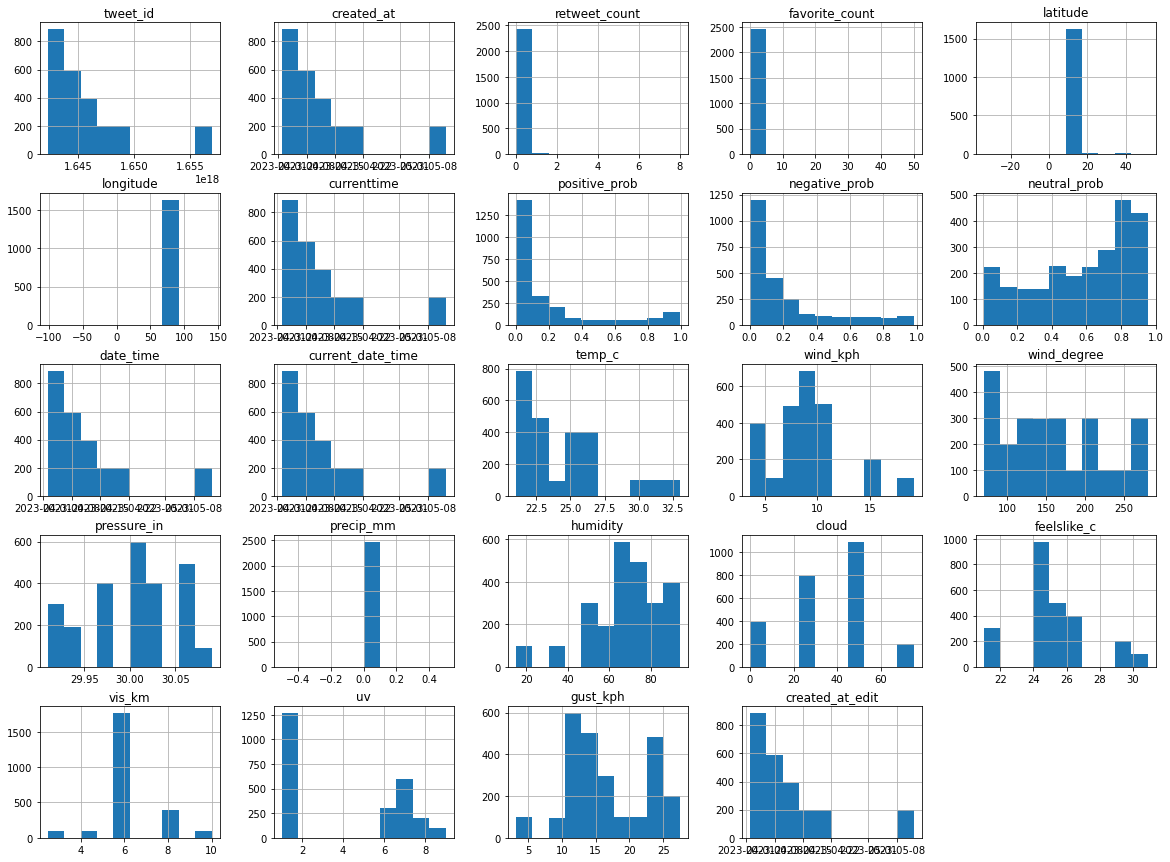

In [192]:
# Visualize the distribution of numerical columns using histograms
df_bangalore.hist(bins=10, figsize=(20,15))
plt.show()

- ### We can see that favorite count and retweet count are very less.
- ### The latitude and longitude are from the same range which is correct.
- ### Positive and negative probabilities have majority of its values less than 0.4 where as neutral has values more than 0.4
- ### Coming to the weather features they are evenly spread across the range with exception of precipitaton, vis and uv

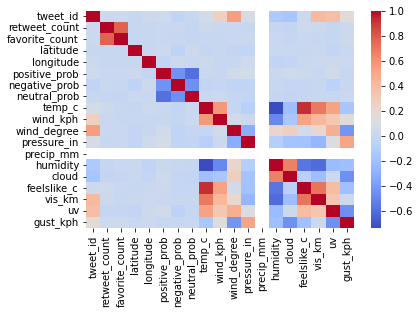

<Figure size 1872x720 with 0 Axes>

In [208]:
# Visualize the correlation between numerical columns using a heatmap
sns.heatmap(df_bangalore.corr(), cmap='coolwarm')
plt.figure(figsize=(26,10))
plt.show()

- ### We can see that retweet count and favorite count are highly correlated
- ### temp has high positive correlation with feels like, wind, vis, uv.

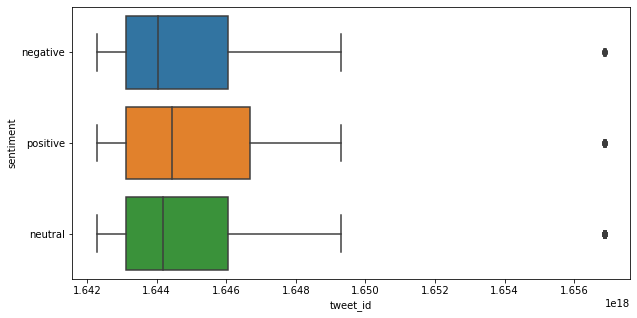

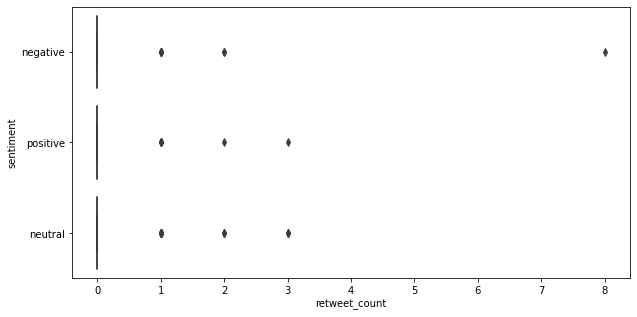

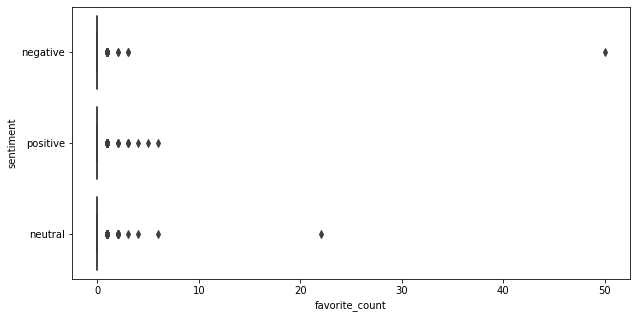

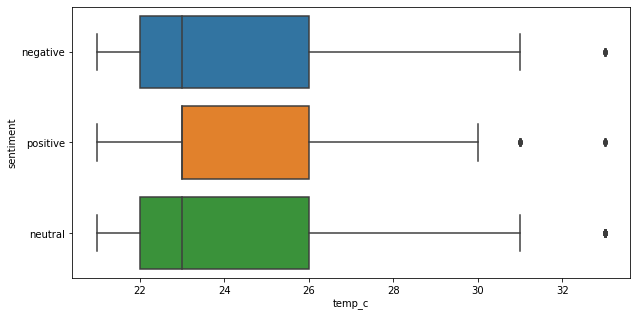

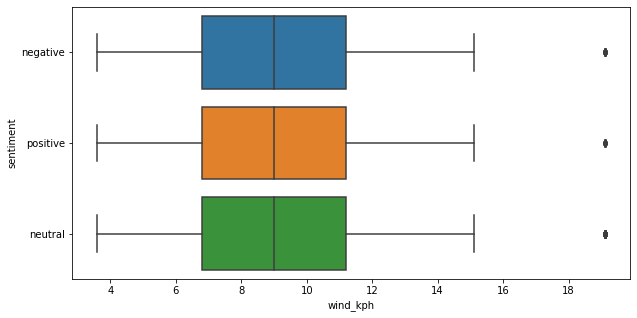

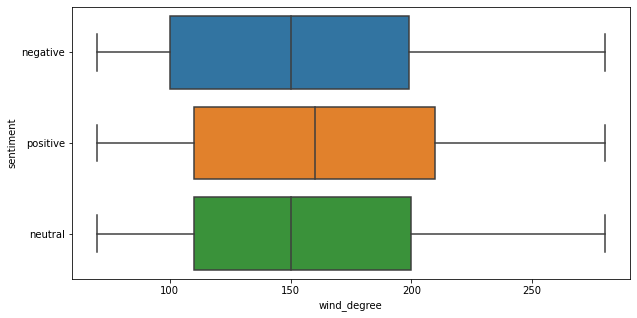

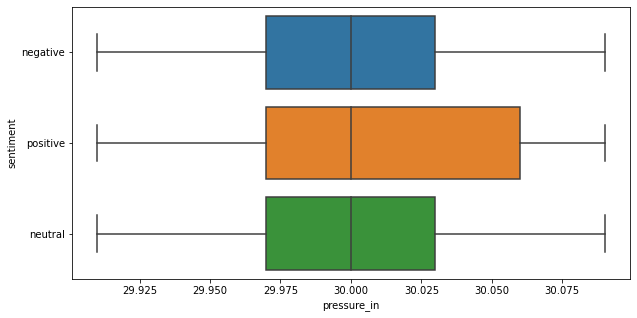

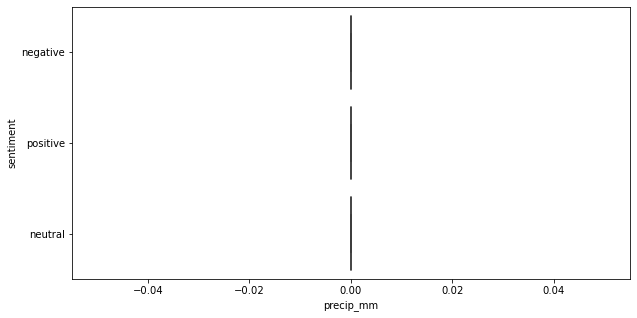

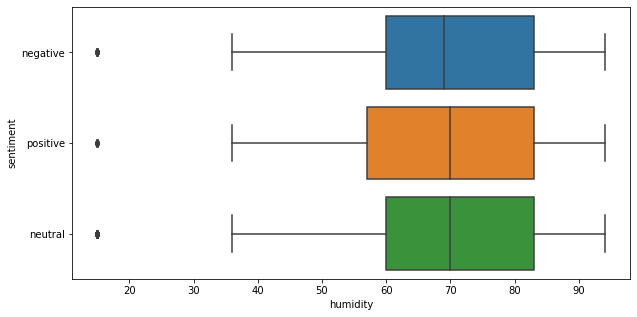

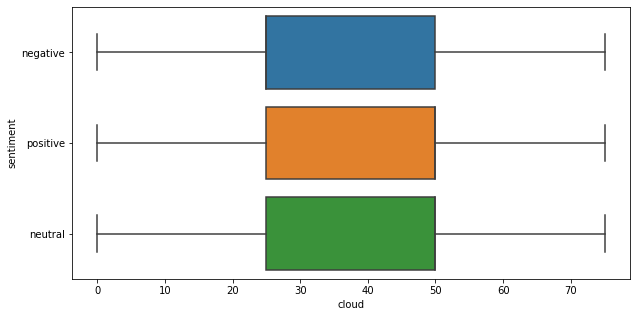

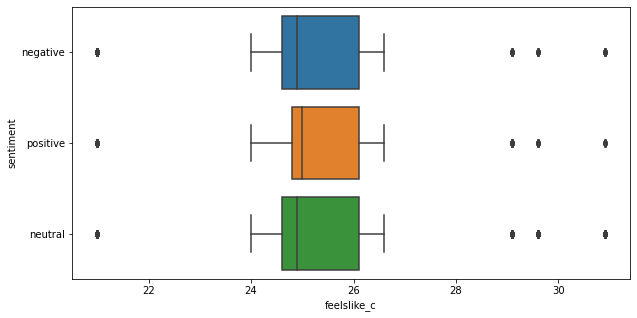

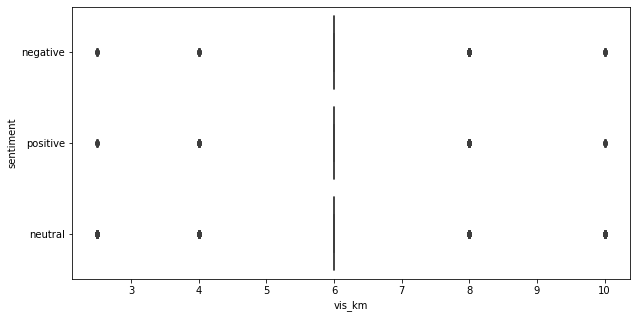

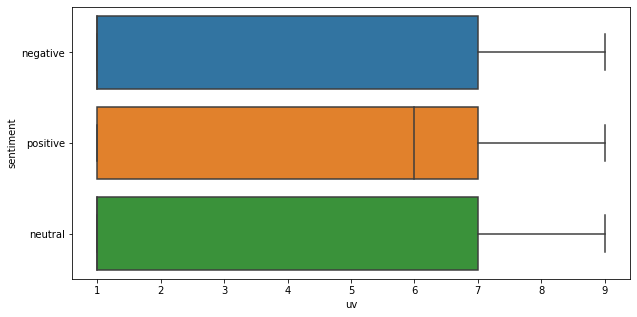

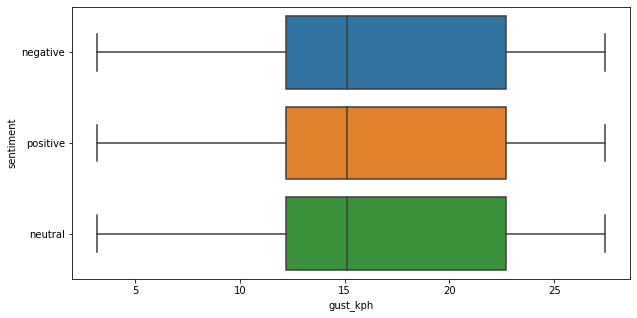

In [194]:
# Visualize the relationship between numerical and categorical columns using boxplots
cols = ['tweet_id', 'retweet_count', 'favorite_count','temp_c', 'wind_kph','wind_degree', 'pressure_in', 'precip_mm', 'humidity','cloud', 'feelslike_c', 'vis_km', 'uv', 'gust_kph']
# for i in range(len(df_bangalore.columns)):
#     if df_bangalore.dtypes[i] != np.object:
for i in cols:
        plt.figure(figsize=(10,5))
        sns.boxplot(x=df_bangalore[i], y='sentiment', data=df_bangalore)
        plt.show()

#### San Jose

In [196]:
# Get the shape of the data (rows, columns)
print("Shape of the DataFrame:", df_sanjose.shape)

Shape of the DataFrame: (2475, 37)


In [197]:
# Get the column names
print("Column names:", df_sanjose.columns)

Column names: Index(['tweet_id', 'tweet', 'sentiment', 'created_at', 'hashtags', 'username',
       'location', 'retweet_count', 'org_tweet', 'org_lang', 'favorite_count',
       'latitude', 'longitude', 'cleaned_tweet', 'currenttime',
       'positive_prob', 'negative_prob', 'neutral_prob', 'place', 'date',
       'time', 'date_time', 'current_date_time', 'temp_c', 'wind_kph',
       'wind_degree', 'wind_dir', 'pressure_in', 'precip_mm', 'humidity',
       'cloud', 'feelslike_c', 'vis_km', 'uv', 'gust_kph', 'conditions',
       'created_at_edit'],
      dtype='object')


In [198]:
# Get the data types of the columns
print("Data types:", df_sanjose.dtypes)

Data types: tweet_id                       int64
tweet                         object
sentiment                     object
created_at            datetime64[ns]
hashtags                      object
username                      object
location                      object
retweet_count                  int64
org_tweet                     object
org_lang                      object
favorite_count                 int64
latitude                     float64
longitude                    float64
cleaned_tweet                 object
currenttime           datetime64[ns]
positive_prob                float64
negative_prob                float64
neutral_prob                 float64
place                         object
date                          object
time                 timedelta64[ns]
date_time             datetime64[ns]
current_date_time     datetime64[ns]
temp_c                       float64
wind_kph                     float64
wind_degree                  float64
wind_dir                  

In [199]:
# Get the summary statistics of the numerical columns
print("Summary statistics of numerical columns:\n", df_sanjose.describe())

Summary statistics of numerical columns:
            tweet_id  retweet_count  favorite_count     latitude    longitude  \
count  2.475000e+03    2475.000000     2475.000000  1571.000000  1571.000000   
mean   1.646168e+18       0.044848        0.228687    36.656264  -120.339599   
std    4.370619e+15       0.476625        1.098717     5.983886    14.690864   
min    1.642301e+18       0.000000        0.000000   -33.892654  -122.419906   
25%    1.643355e+18       0.000000        0.000000    37.336166  -122.036349   
50%    1.644429e+18       0.000000        0.000000    37.336166  -121.890591   
75%    1.646696e+18       0.000000        0.000000    37.368830  -121.890591   
max    1.656874e+18      14.000000       25.000000    42.434757   151.214196   

       positive_prob  negative_prob  neutral_prob                       time  \
count    2475.000000    2475.000000   2475.000000                       2475   
mean        0.251556       0.248409      0.500035  0 days 15:16:35.684848484 

In [200]:
# Get the number of missing values in each column
print("Number of missing values in each column:\n", df_sanjose.isnull().sum())

Number of missing values in each column:
 tweet_id               0
tweet                  0
sentiment              0
created_at             0
hashtags               0
username               0
location               0
retweet_count          0
org_tweet              0
org_lang               0
favorite_count         0
latitude             904
longitude            904
cleaned_tweet          0
currenttime            0
positive_prob          0
negative_prob          0
neutral_prob           0
place                  0
date                   0
time                   0
date_time              0
current_date_time      0
temp_c                 0
wind_kph               0
wind_degree            0
wind_dir               0
pressure_in            0
precip_mm              0
humidity               0
cloud                  0
feelslike_c            0
vis_km                 0
uv                     0
gust_kph               0
conditions             0
created_at_edit        0
dtype: int64


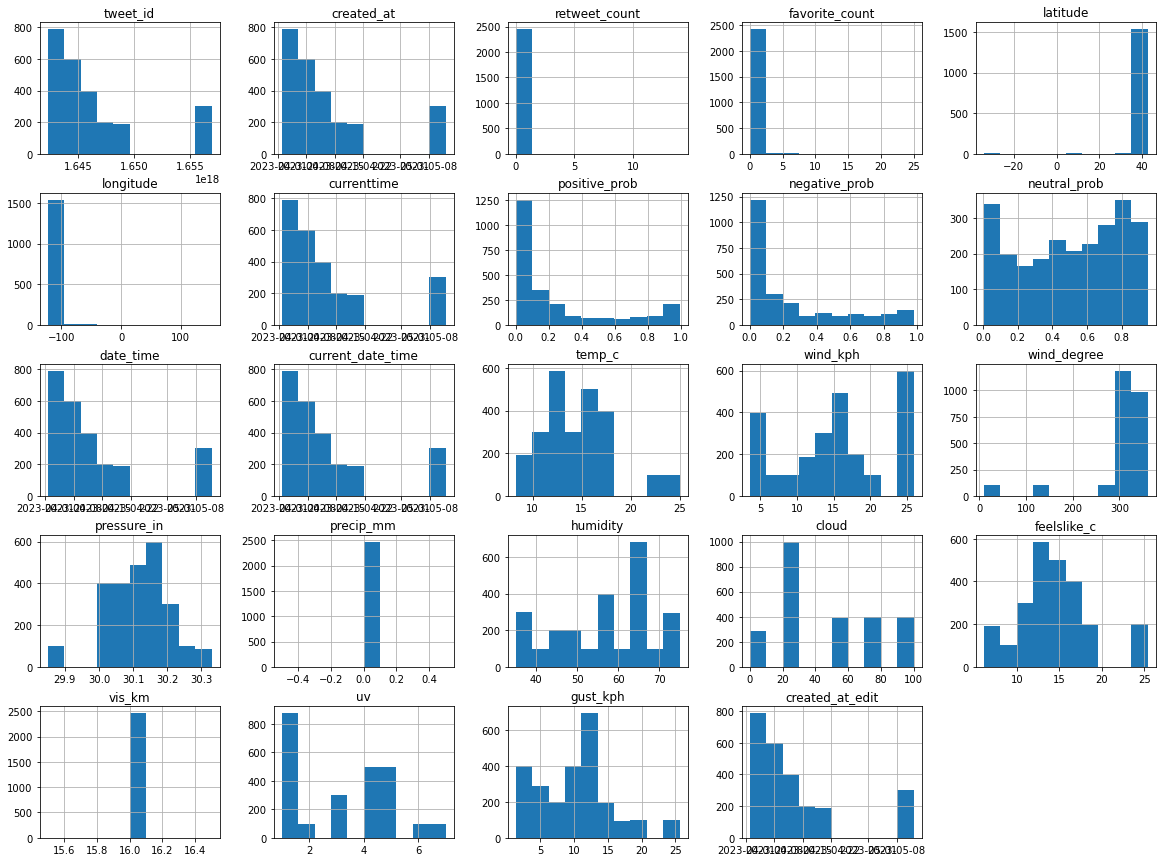

In [201]:
# Visualize the distribution of numerical columns using histograms
df_sanjose.hist(bins=10, figsize=(20,15))
plt.show()

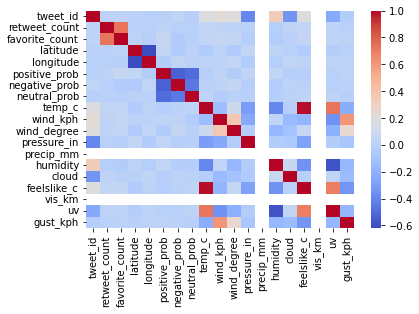

In [209]:
# Visualize the correlation between numerical columns using a heatmap
sns.heatmap(df_sanjose.corr(), cmap='coolwarm')
plt.show()

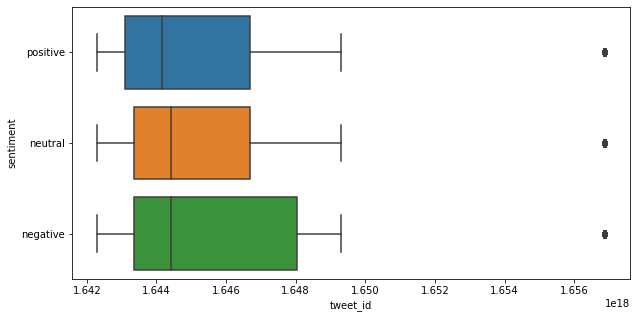

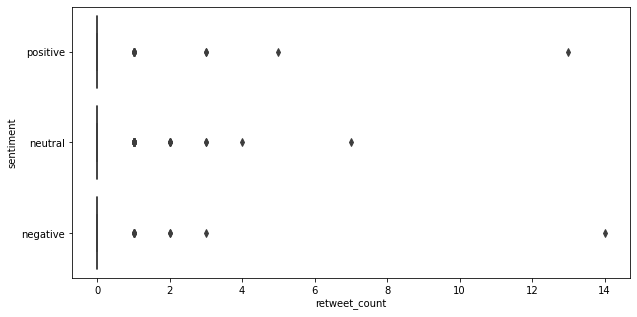

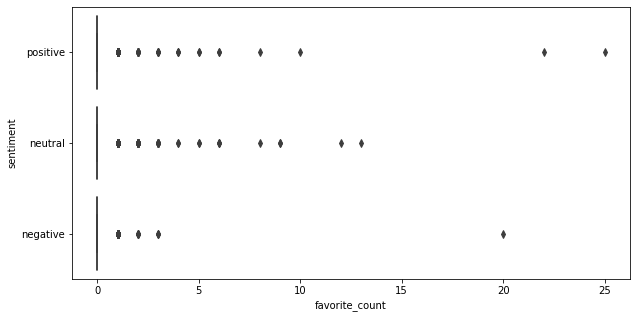

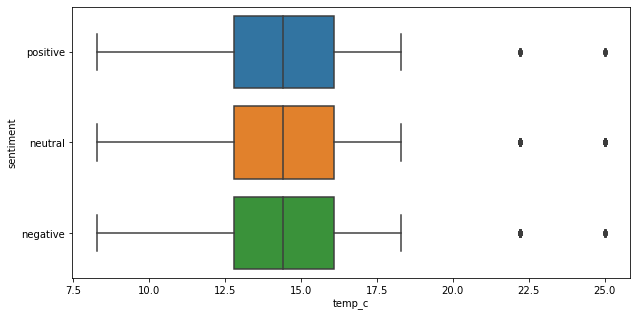

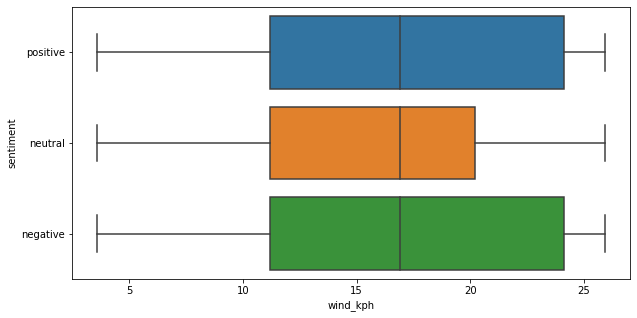

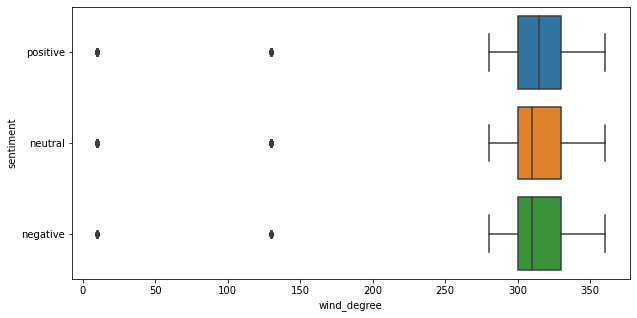

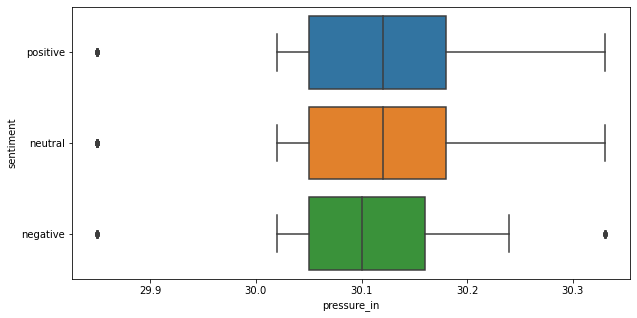

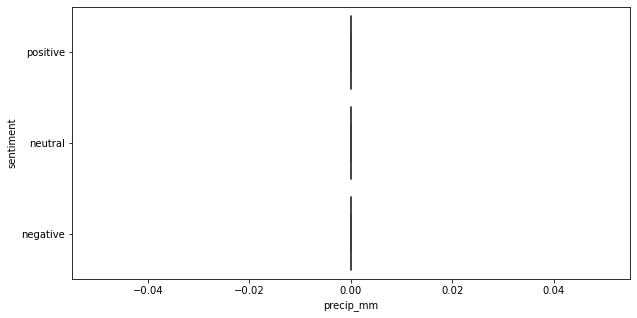

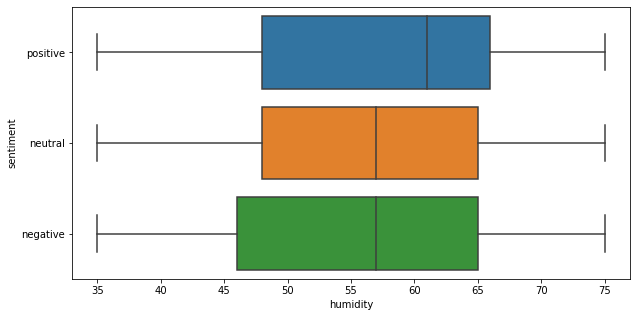

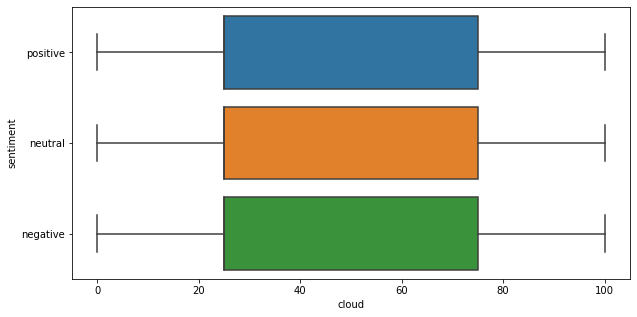

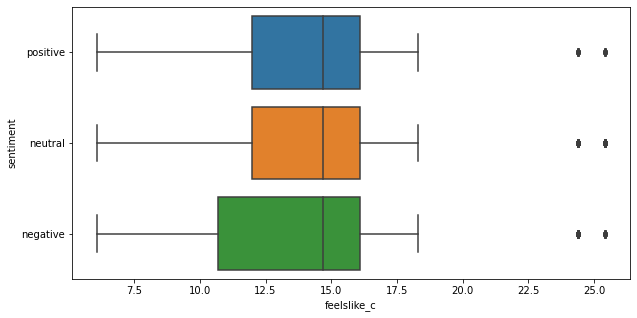

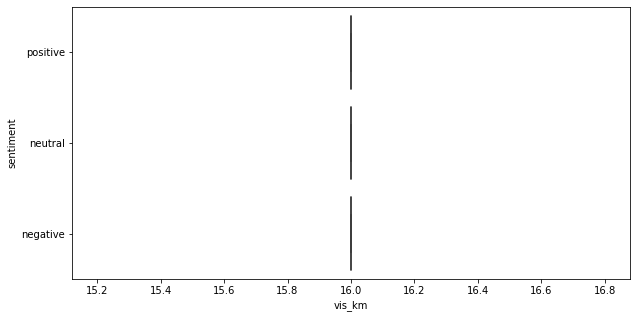

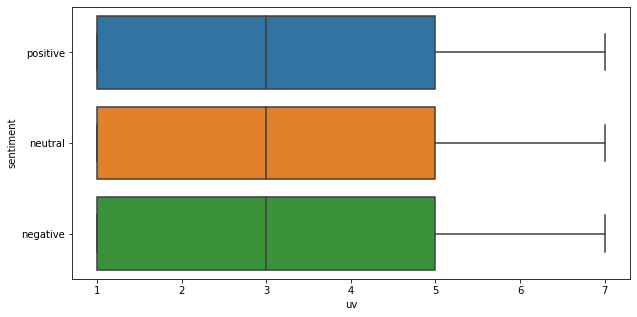

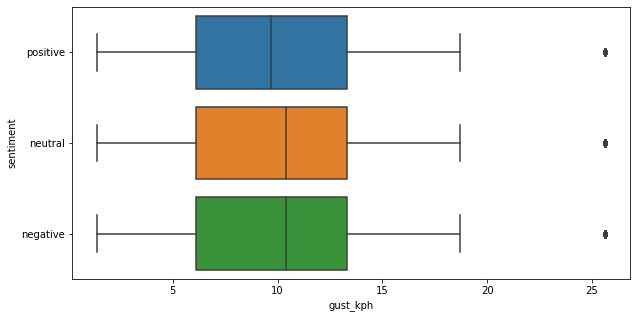

In [203]:
# Visualize the relationship between numerical and categorical columns using boxplots
cols = ['tweet_id', 'retweet_count', 'favorite_count','temp_c', 'wind_kph','wind_degree', 'pressure_in', 'precip_mm', 'humidity','cloud', 'feelslike_c', 'vis_km', 'uv', 'gust_kph']
# for i in range(len(df_sanjose.columns)):
#     if df_sanjose.dtypes[i] != np.object:
for i in cols:
        plt.figure(figsize=(10,5))
        sns.boxplot(x=df_sanjose[i], y='sentiment', data=df_sanjose)
        plt.show()

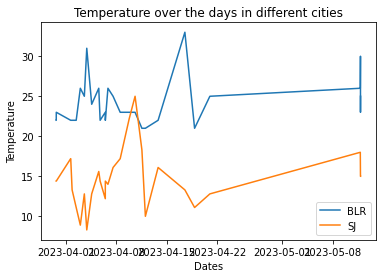

In [163]:
# using .plot method to plot Temperature.
# we have passed colors as a list
plt.plot(df_sanjose_bangalore_weather['date_time'],df_sanjose_bangalore_weather['blr_temp'],  label = 'BLR')
plt.plot(df_sanjose_bangalore_weather['date_time'],df_sanjose_bangalore_weather['sj_temp'], label = 'SJ')

plt.legend(loc ="lower right")
# adding title
plt.title('Temperature over the days in different cities')
  
plt.ylabel('Temperature')

# adding label to x-axis
plt.xlabel('Dates')
  
# adding legend.
plt.legend()

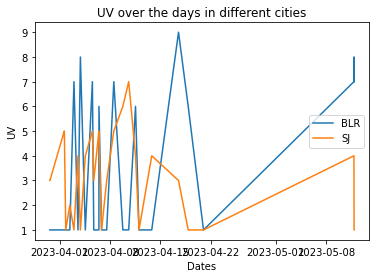

In [313]:
# using .plot method to plot Temperature.
# we have passed colors as a list
plt.plot(df_sanjose_bangalore_weather['date_time'],df_sanjose_bangalore_weather['blr_uv'],  label = 'BLR')
plt.plot(df_sanjose_bangalore_weather['date_time'],df_sanjose_bangalore_weather['sj_uv'], label = 'SJ')

plt.legend(loc ="lower right")
# adding title
plt.title('UV over the days in different cities')
  
plt.ylabel('UV')

# adding label to x-axis
plt.xlabel('Dates')
  
# adding legend.
plt.legend()

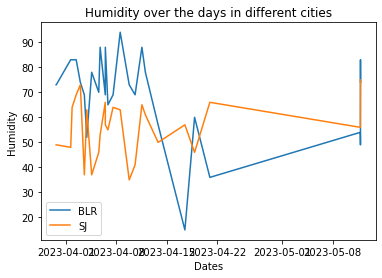

In [314]:
# using .plot method to plot Temperature.
# we have passed colors as a list
plt.plot(df_sanjose_bangalore_weather['date_time'],df_sanjose_bangalore_weather['blr_hum'],  label = 'BLR')
plt.plot(df_sanjose_bangalore_weather['date_time'],df_sanjose_bangalore_weather['sj_hum'], label = 'SJ')

plt.legend(loc ="lower right")
# adding title
plt.title('Humidity over the days in different cities')
  
plt.ylabel('Humidity')

# adding label to x-axis
plt.xlabel('Dates')
  
# adding legend.
plt.legend()

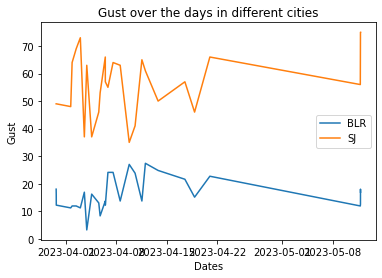

In [315]:
# using .plot method to plot Temperature.
# we have passed colors as a list
plt.plot(df_sanjose_bangalore_weather['date_time'],df_sanjose_bangalore_weather['blr_gust'],  label = 'BLR')
plt.plot(df_sanjose_bangalore_weather['date_time'],df_sanjose_bangalore_weather['sj_gust'],  label = 'SJ')

plt.legend(loc ="lower right")
# adding title
plt.title('Gust over the days in different cities')
  
plt.ylabel('Gust')

# adding label to x-axis
plt.xlabel('Dates')
  
# adding legend.
plt.legend()

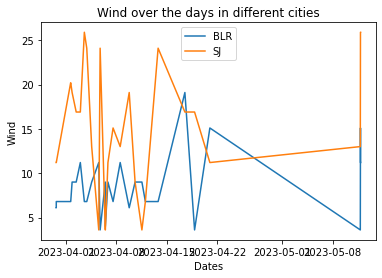

In [316]:
# using .plot method to plot Temperature.
# we have passed colors as a list
plt.plot(df_sanjose_bangalore_weather['date_time'],df_sanjose_bangalore_weather['blr_wind'], label = 'BLR')
plt.plot(df_sanjose_bangalore_weather['date_time'],df_sanjose_bangalore_weather['sj_wind'], label = 'SJ')

plt.legend(loc ="lower right")
# adding title
plt.title('Wind over the days in different cities')
  
plt.ylabel('Wind')

# adding label to x-axis
plt.xlabel('Dates')
  
# adding legend.
plt.legend()

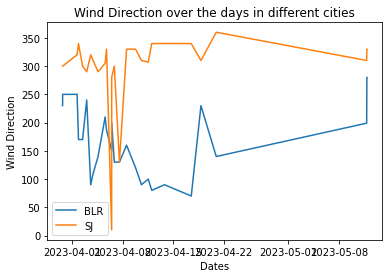

In [317]:
# using .plot method to plot Temperature.
# we have passed colors as a list
plt.plot(df_sanjose_bangalore_weather['date_time'],df_sanjose_bangalore_weather['blr_wd'], label = 'BLR')
plt.plot(df_sanjose_bangalore_weather['date_time'],df_sanjose_bangalore_weather['sj_wd'], label = 'SJ')

plt.legend(loc ="lower right")
# adding title
plt.title('Wind Direction over the days in different cities')
  
plt.ylabel('Wind Direction')

# adding label to x-axis
plt.xlabel('Dates')
  
# adding legend.
plt.legend()

In [144]:
df_blr_senti = df_bangalore[['sentiment','tweet_id']].groupby(by = "sentiment",as_index = False).count()
df_blr_senti

,sentiment,tweet_id
0,negative,385
1,neutral,1693
2,positive,395


<BarContainer object of 3 artists>

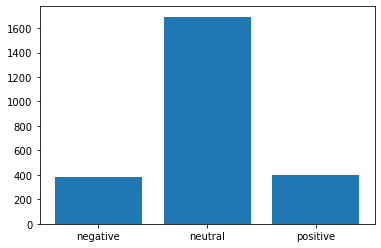

In [145]:
plt.bar(df_blr_senti["sentiment"],df_blr_senti["tweet_id"])

In [146]:
df_sj_senti = df_sanjose[['sentiment','tweet_id']].groupby(by = "sentiment",as_index = False).count()
df_sj_senti

,sentiment,tweet_id
0,negative,547
1,neutral,1418
2,positive,510


<BarContainer object of 3 artists>

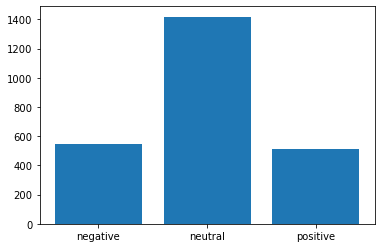

In [147]:
plt.bar(df_sj_senti["sentiment"],df_sj_senti["tweet_id"])

In [149]:
df_blr_cond = df_bangalore[['conditions','tweet_id']].groupby(by = "conditions",as_index = False).count()
df_blr_cond

,conditions,tweet_id
0,Clear,192
1,Mist,200
2,Partly cloudy,1881
3,Sunny,200


<BarContainer object of 4 artists>

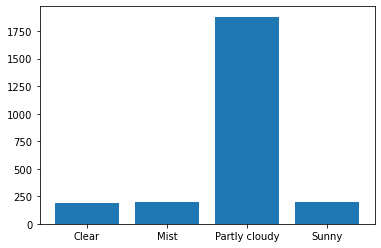

In [151]:
plt.bar(df_blr_cond["conditions"],df_blr_cond["tweet_id"])

In [152]:
df_sj_cond = df_sanjose[['conditions','tweet_id']].groupby(by = "conditions",as_index = False).count()
df_sj_cond

,conditions,tweet_id
0,Clear,187
1,Overcast,400
2,Partly cloudy,1788
3,Sunny,100


<BarContainer object of 4 artists>

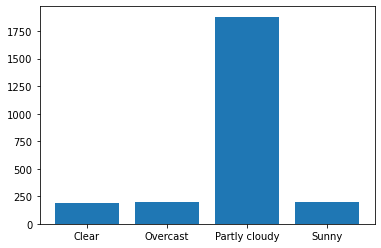

In [153]:
plt.bar(df_sj_cond["conditions"],df_blr_cond["tweet_id"])

C:\Users\Dell\AppData\Local\Temp\ipykernel_23512\335824261.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


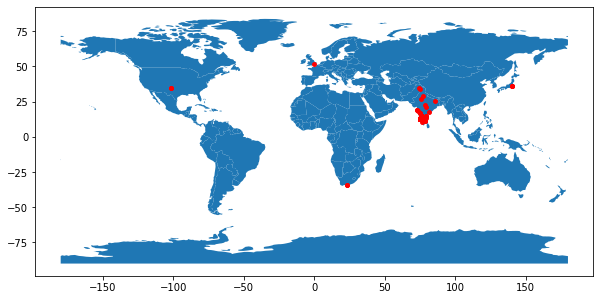

In [162]:
# !pip install shapely
# !pip install geopandas
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

# df = pd.read_csv("Long_Lats.csv", delimiter=',', skiprows=0, low_memory=False)

geometry = [Point(xy) for xy in zip(df_bangalore['longitude'], df_bangalore['latitude'])]
gdf = GeoDataFrame(df_bangalore, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

C:\Users\Dell\AppData\Local\Temp\ipykernel_23512\499286105.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


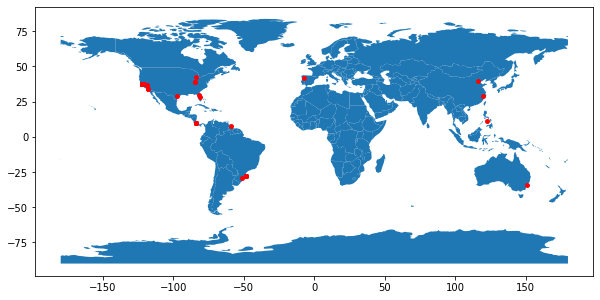

In [161]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(df_sanjose['longitude'], df_sanjose['latitude'])]
gdf = GeoDataFrame(df_sanjose, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [21]:
weather = list(df_bangalore['conditions'].unique())
weather

['Partly cloudy', 'Mist', 'Clear', 'Sunny']

## Predicting weather condition based on sentiment

## For Banglore

### Linear Regression for bangalore

In [252]:
# doing data manipulation to combine data
df_bangalore['created_at_edit'] = df_bangalore['created_at'].values.astype('<M8[m]')
df_bangalore

df_bangalore_grouped = df_bangalore.groupby(by = "created_at_edit",as_index = True).mean().reset_index()
print(df_bangalore_grouped.columns)

Index(['created_at_edit', 'tweet_id', 'retweet_count', 'favorite_count',
       'latitude', 'longitude', 'positive_prob', 'negative_prob',
       'neutral_prob', 'temp_c', 'wind_kph', 'wind_degree', 'pressure_in',
       'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'vis_km', 'uv',
       'gust_kph'],
      dtype='object')


In [259]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and preprocess the data
X = df_bangalore_grouped[['positive_prob', 'negative_prob', 'neutral_prob']] # independent variables
y = df_bangalore_grouped['temp_c'] # dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}, MAE: {mae}, R-squared: {r2}")

MSE: 6.200991202973913, MAE: 1.893715095091611, R-squared: 0.018830505858558055


### The regression was a very bad model so I am trying logistic regression next

In [270]:
grouped_df_bangalore = df_bangalore.groupby(['created_at_edit', 'conditions']).mean().reset_index()

grouped_df_bangalore.groupby(by = "conditions",as_index = False).count()

,conditions,created_at_edit,tweet_id,retweet_count,favorite_count,latitude,longitude,positive_prob,negative_prob,neutral_prob,...,wind_kph,wind_degree,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph
0,Clear,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
1,Mist,8,8,8,8,1,1,8,8,8,...,8,8,8,8,8,8,8,8,8,8
2,Partly cloudy,100,100,100,100,69,69,100,100,100,...,100,100,100,100,100,100,100,100,100,100
3,Sunny,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7


In [271]:
# since the data is very imbalanced I am upsampling the minority classes i.e sunny, clear, mist

import pandas as pd
from sklearn.utils import resample

# Define the minority class label
majority_class = 'Partly cloudy'

# Split the dataframe into minority and majority classes
majority_df = grouped_df_bangalore[grouped_df_bangalore['conditions'] == majority_class]
minority_df = grouped_df_bangalore[grouped_df_bangalore['conditions'] != majority_class]

# Upsample the minority class to the size of the majority class
upsampled_minority_df = resample(minority_df,
                                 replace=True,
                                 n_samples=len(majority_df)*3,
                                 random_state=42)

# Combine the upsampled minority class with the majority class
upsampled_df_bangalore = pd.concat([upsampled_minority_df, majority_df])

# Shuffle the rows of the upsampled dataframe
upsampled_df_bangalore = upsampled_df_bangalore.sample(frac=1, random_state=42)

In [272]:
# now the data looks more balanced
upsampled_df_bangalore.groupby(by = "conditions",as_index = False).count()

,conditions,created_at_edit,tweet_id,retweet_count,favorite_count,latitude,longitude,positive_prob,negative_prob,neutral_prob,...,wind_kph,wind_degree,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph
0,Clear,87,87,87,87,87,87,87,87,87,...,87,87,87,87,87,87,87,87,87,87
1,Mist,122,122,122,122,19,19,122,122,122,...,122,122,122,122,122,122,122,122,122,122
2,Partly cloudy,100,100,100,100,69,69,100,100,100,...,100,100,100,100,100,100,100,100,100,100
3,Sunny,91,91,91,91,91,91,91,91,91,...,91,91,91,91,91,91,91,91,91,91


### Logistic Regression for Bangalore

In [324]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report

X = upsampled_df_bangalore[['positive_prob', 'negative_prob', 'neutral_prob']]
y = upsampled_df_bangalore['conditions']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model and fit it to the training data
model_bangalore = LogisticRegression(random_state=42)
model_bangalore.fit(X_train, y_train)

# Use the trained model to predict the conditions for the test set
y_pred = model_bangalore.predict(X_test)

# Evaluate the performance of the model
report = classification_report(y_test, y_pred)
# r2 = recall_score(y_test, y_pred)
print(f"Report: {report}")

MSE:                precision    recall  f1-score   support

        Clear       0.00      0.00      0.00        16
         Mist       0.37      1.00      0.54        25
Partly cloudy       0.40      0.25      0.31        16
        Sunny       0.50      0.04      0.08        23

     accuracy                           0.38        80
    macro avg       0.32      0.32      0.23        80
 weighted avg       0.34      0.38      0.25        80



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Tree for Bangalore

Accuracy: 0.725
               precision    recall  f1-score   support

        Clear       0.86      0.79      0.83        24
         Mist       0.62      1.00      0.77        38
Partly cloudy       0.40      0.07      0.12        27
        Sunny       0.88      0.90      0.89        31

     accuracy                           0.73       120
    macro avg       0.69      0.69      0.65       120
 weighted avg       0.69      0.72      0.67       120



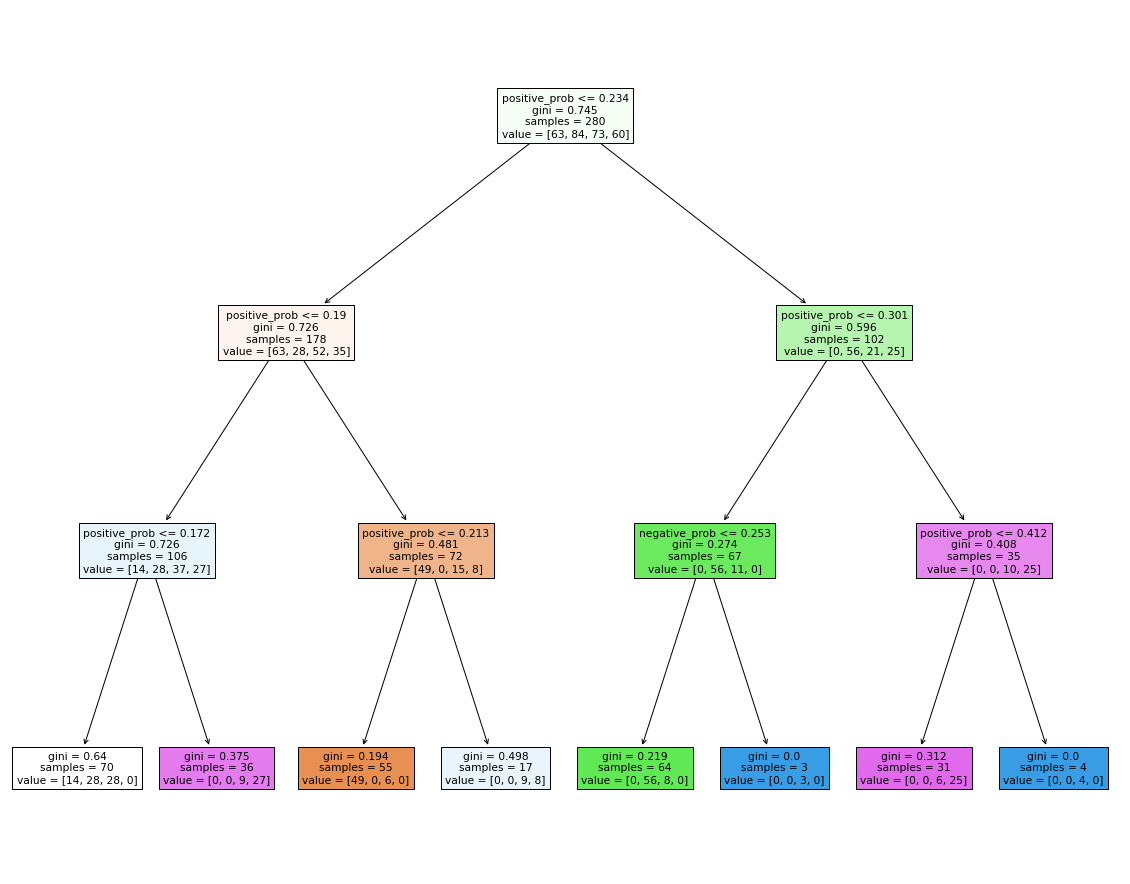

<Figure size 432x288 with 0 Axes>

In [318]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Assuming you have a dataframe called 'df' with your data
X = upsampled_df_bangalore[['positive_prob', 'negative_prob', 'neutral_prob']]
y = upsampled_df_bangalore['conditions']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)
plt.figure(figsize=(20, 16))
tree.plot_tree(clf, feature_names=X.columns, filled=True)
plt.show()
plt.savefig('C:/Users/Dell/Desktop/notes/San Jose State University/Sem2/CMPE 256-01 Advanced Data Mining/Project/decision_tree_blr_cond.png')

### Decision Tree for predicting temperature for bangalore

In [327]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# Assuming you have a dataframe called 'df' with your data
X = upsampled_df_bangalore[['positive_prob', 'negative_prob', 'neutral_prob']]
y = upsampled_df_bangalore['temp_c']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.8166666666666667
              precision    recall  f1-score   support

        21.0       0.93      0.90      0.92        30
        22.0       0.83      0.73      0.78        26
        23.0       0.70      0.67      0.68        21
        24.0       0.00      0.00      0.00         0
        25.0       0.78      1.00      0.88         7
        26.0       0.78      0.91      0.84        23
        30.0       0.00      0.00      0.00         3
        33.0       1.00      1.00      1.00        10

    accuracy                           0.82       120
   macro avg       0.63      0.65      0.64       120
weighted avg       0.81      0.82      0.81       120



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classif

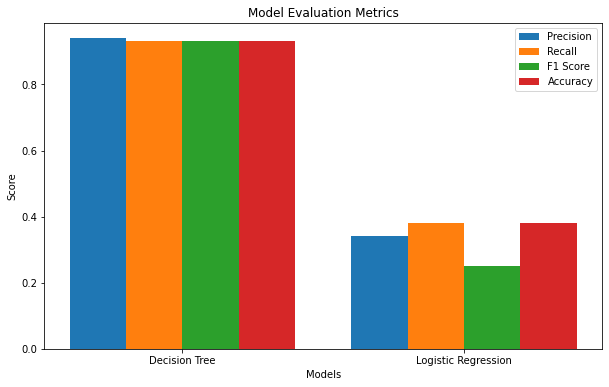

In [263]:
# Define the model names and evaluation metrics
model_names = ['Decision Tree', 'Logistic Regression']
precision = [0.94,0.34]
recall = [0.93,0.38]
f1_score = [0.93,0.25]
accuracy = [0.93,0.38]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = range(len(model_names))
r2 = [x + bar_width for x in r1]
r3 = [x + 2 * bar_width for x in r1]
r4 = [x + 3 * bar_width for x in r1]

plt.figure(figsize=(10, 6))


# Create the bar chart
plt.bar(r1, precision, width=bar_width, label='Precision')
plt.bar(r2, recall, width=bar_width, label='Recall')
plt.bar(r3, f1_score, width=bar_width, label='F1 Score')
plt.bar(r4, accuracy, width=bar_width, label='Accuracy')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.xticks([r + 1.5 * bar_width for r in range(len(model_names))], model_names)
plt.legend(loc ="upper right")

# Display the bar chart
plt.show()

### San Jose

In [22]:
df_sanjose['created_at_edit'] = df_sanjose['created_at'].values.astype('<M8[m]')
# print(df)
grouped_df_sanjose = df_sanjose.groupby(['created_at_edit', 'conditions']).mean().reset_index()
grouped_df_sanjose

,created_at_edit,conditions,tweet_id,retweet_count,favorite_count,latitude,longitude,positive_prob,negative_prob,neutral_prob,...,wind_kph,wind_degree,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph
0,2023-04-01 22:59:00,Partly cloudy,1.642301e+18,0.000000,0.428571,32.760607,-115.633521,0.371691,0.205234,0.423075,...,20.2,320.0,30.21,0.0,48.0,25.0,17.2,16.0,5.0,14.0
1,2023-04-01 23:00:00,Partly cloudy,1.642301e+18,0.000000,0.230769,37.346583,-121.964773,0.364673,0.116411,0.518915,...,20.2,320.0,30.21,0.0,48.0,25.0,17.2,16.0,5.0,14.0
2,2023-04-01 23:01:00,Partly cloudy,1.642301e+18,0.000000,0.391304,37.331539,-121.909346,0.254811,0.159215,0.585974,...,20.2,320.0,30.21,0.0,48.0,25.0,17.2,16.0,5.0,14.0
3,2023-04-01 23:02:00,Partly cloudy,1.642301e+18,0.136364,0.545455,37.359626,-121.954745,0.202828,0.260503,0.536668,...,20.2,320.0,30.21,0.0,48.0,25.0,17.2,16.0,5.0,14.0
4,2023-04-01 23:03:00,Partly cloudy,1.642302e+18,0.000000,0.000000,37.338764,-121.928972,0.168970,0.383977,0.447052,...,20.2,320.0,30.21,0.0,48.0,25.0,17.2,16.0,5.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,2023-05-12 04:06:00,Partly cloudy,1.656873e+18,0.000000,0.181818,37.343044,-121.948613,0.194642,0.239504,0.565854,...,25.9,330.0,30.04,0.0,75.0,25.0,15.2,16.0,1.0,9.7
151,2023-05-12 04:07:00,Partly cloudy,1.656874e+18,0.200000,0.866667,37.349337,-121.973397,0.294282,0.270494,0.435224,...,25.9,330.0,30.04,0.0,75.0,25.0,15.2,16.0,1.0,9.7
152,2023-05-12 04:08:00,Partly cloudy,1.656874e+18,0.000000,0.000000,37.350352,-121.936879,0.155337,0.316712,0.527952,...,25.9,330.0,30.04,0.0,75.0,25.0,15.2,16.0,1.0,9.7
153,2023-05-12 04:09:00,Partly cloudy,1.656874e+18,0.000000,0.052632,37.324573,-121.891190,0.167028,0.296840,0.536132,...,25.9,330.0,30.04,0.0,75.0,25.0,15.2,16.0,1.0,9.7


In [23]:
grouped_df_sanjose.groupby(by = "conditions",as_index = False).count()

,conditions,created_at_edit,tweet_id,retweet_count,favorite_count,latitude,longitude,positive_prob,negative_prob,neutral_prob,...,wind_kph,wind_degree,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph
0,Clear,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
1,Overcast,21,21,21,21,5,5,21,21,21,...,21,21,21,21,21,21,21,21,21,21
2,Partly cloudy,115,115,115,115,93,93,115,115,115,...,115,115,115,115,115,115,115,115,115,115
3,Sunny,5,5,5,5,0,0,5,5,5,...,5,5,5,5,5,5,5,5,5,5


### Upsampling

In [24]:
# upsampling again like how we did for the banaglore data
import pandas as pd
from sklearn.utils import resample

# Define the minority class label
majority_class = 'Partly cloudy'

# Split the dataframe into minority and majority classes
majority_df = grouped_df_sanjose[grouped_df_sanjose['conditions'] == majority_class]
minority_df = grouped_df_sanjose[grouped_df_sanjose['conditions'] != majority_class]

# Upsample the minority class to the size of the majority class
upsampled_minority_df = resample(minority_df,
                                 replace=True,
                                 n_samples=len(majority_df)*2,
                                 random_state=42)

# Combine the upsampled minority class with the majority class
upsampled_df_sanjose = pd.concat([upsampled_minority_df, majority_df])

# Shuffle the rows of the upsampled dataframe
upsampled_df_sanjose = upsampled_df_sanjose.sample(frac=1, random_state=42)

In [25]:
upsampled_df_sanjose.groupby(by = "conditions",as_index = False).count()

,conditions,created_at_edit,tweet_id,retweet_count,favorite_count,latitude,longitude,positive_prob,negative_prob,neutral_prob,...,wind_kph,wind_degree,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph
0,Clear,83,83,83,83,83,83,83,83,83,...,83,83,83,83,83,83,83,83,83,83
1,Overcast,127,127,127,127,35,35,127,127,127,...,127,127,127,127,127,127,127,127,127,127
2,Partly cloudy,115,115,115,115,93,93,115,115,115,...,115,115,115,115,115,115,115,115,115,115
3,Sunny,20,20,20,20,0,0,20,20,20,...,20,20,20,20,20,20,20,20,20,20


In [26]:
import pandas as pd
from sklearn.utils import resample

# Define the minority class label
minority_class = 'Sunny'

# Split the dataframe into minority and majority classes
majority_df = upsampled_df_sanjose[upsampled_df_sanjose['conditions'] != minority_class]
minority_df = upsampled_df_sanjose[upsampled_df_sanjose['conditions'] == minority_class]

# Upsample the minority class to the size of the majority class
upsampled_minority_df = resample(minority_df,
                                 replace=True,
                                 n_samples=len(majority_df)//3,
                                 random_state=42)

# Combine the upsampled minority class with the majority class
upsampled_df_sanjose = pd.concat([upsampled_minority_df, majority_df])

# Shuffle the rows of the upsampled dataframe
upsampled_df_sanjose = upsampled_df_sanjose.sample(frac=1, random_state=42)


In [27]:
upsampled_df_sanjose.groupby(by = "conditions",as_index = False).count()

,conditions,created_at_edit,tweet_id,retweet_count,favorite_count,latitude,longitude,positive_prob,negative_prob,neutral_prob,...,wind_kph,wind_degree,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph
0,Clear,83,83,83,83,83,83,83,83,83,...,83,83,83,83,83,83,83,83,83,83
1,Overcast,127,127,127,127,35,35,127,127,127,...,127,127,127,127,127,127,127,127,127,127
2,Partly cloudy,115,115,115,115,93,93,115,115,115,...,115,115,115,115,115,115,115,115,115,115
3,Sunny,108,108,108,108,0,0,108,108,108,...,108,108,108,108,108,108,108,108,108,108


### Logistic Regression for San Jose

In [329]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report


# Assuming the data is in a DataFrame called 'df'
X = upsampled_df_sanjose[['positive_prob', 'negative_prob', 'neutral_prob']]
y = upsampled_df_sanjose['conditions']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model and fit it to the training data
model_sanjose = LogisticRegression(random_state=42)
model_sanjose.fit(X_train, y_train)

# Use the trained model to predict the conditions for the test set
y_pred = model_sanjose.predict(X_test)

# Evaluate the performance of the model
classificationreport = classification_report(y_test, y_pred)

print(classificationreport)

               precision    recall  f1-score   support

        Clear       0.00      0.00      0.00        15
     Overcast       0.22      0.84      0.34        19
Partly cloudy       0.31      0.20      0.24        20
        Sunny       0.00      0.00      0.00        33

     accuracy                           0.23        87
    macro avg       0.13      0.26      0.15        87
 weighted avg       0.12      0.23      0.13        87



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Tree for San Jose

Accuracy: 0.9384615384615385
               precision    recall  f1-score   support

        Clear       0.89      1.00      0.94        25
     Overcast       0.88      1.00      0.93        28
Partly cloudy       1.00      0.72      0.84        29
        Sunny       0.98      1.00      0.99        48

     accuracy                           0.94       130
    macro avg       0.94      0.93      0.93       130
 weighted avg       0.94      0.94      0.94       130



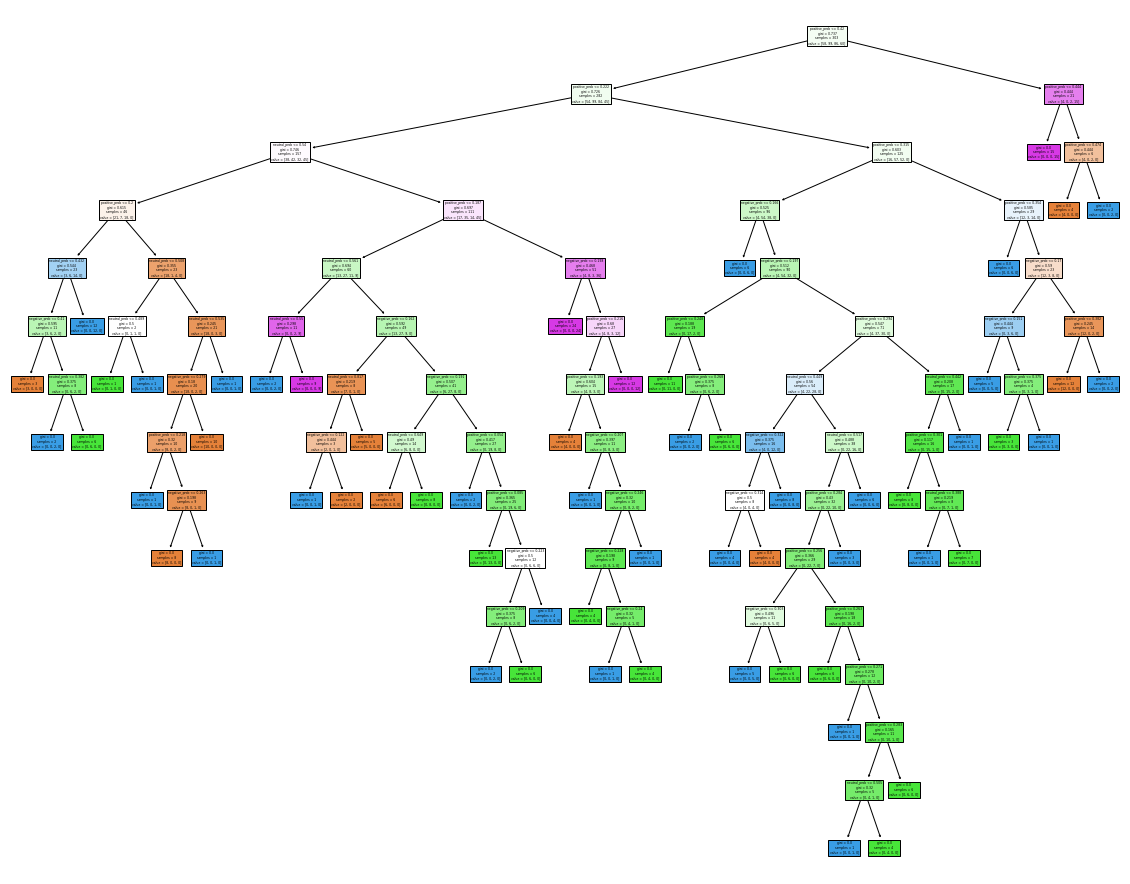

<Figure size 432x288 with 0 Axes>

In [268]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import tree

# Assuming you have a dataframe called 'df' with your data
X = upsampled_df_sanjose[['positive_prob', 'negative_prob', 'neutral_prob']]
y = upsampled_df_sanjose['conditions']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)
plt.figure(figsize=(20, 16))
tree.plot_tree(clf, feature_names=X.columns, filled=True)
plt.show()
plt.savefig('C:/Users/Dell/Desktop/notes/San Jose State University/Sem2/CMPE 256-01 Advanced Data Mining/Project/decision_tree_sj_cond.png')

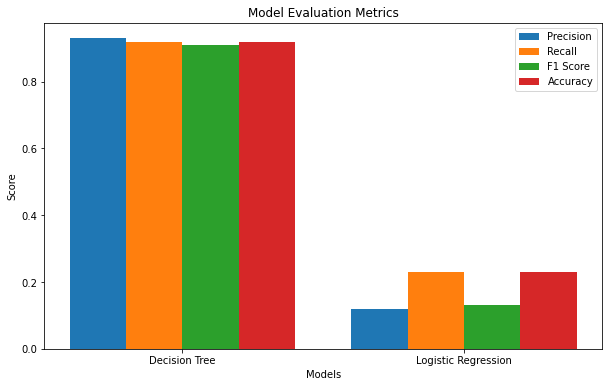

In [262]:
# Define the model names and evaluation metrics
model_names = ['Decision Tree', 'Logistic Regression']
precision = [0.93,0.12]
recall = [0.92,0.23]
f1_score = [0.91,0.13]
accuracy = [0.92,0.23]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = range(len(model_names))
r2 = [x + bar_width for x in r1]
r3 = [x + 2 * bar_width for x in r1]
r4 = [x + 3 * bar_width for x in r1]

plt.figure(figsize=(10, 6))


# Create the bar chart
plt.bar(r1, precision, width=bar_width, label='Precision')
plt.bar(r2, recall, width=bar_width, label='Recall')
plt.bar(r3, f1_score, width=bar_width, label='F1 Score')
plt.bar(r4, accuracy, width=bar_width, label='Accuracy')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.xticks([r + 1.5 * bar_width for r in range(len(model_names))], model_names)
plt.legend(loc ="upper right")

# Display the bar chart
plt.show()

# Predicting sentiment using weather details

## Bangalore

In [46]:
df_bangalore[df_bangalore['neutral_prob']<df_bangalore['positive_prob']]
grouped_df_bangalore_senti = df_bangalore.groupby(["sentiment",'conditions'])

In [47]:
grouped_df_bangalore_senti = df_bangalore.groupby(["sentiment","conditions"]).count().reset_index()

In [48]:
grouped_df_bangalore_senti

,sentiment,conditions,tweet_id,tweet,created_at,hashtags,username,location,retweet_count,org_tweet,...,wind_dir,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,created_at_edit
0,negative,Clear,37,37,37,37,37,37,37,37,...,37,37,37,37,37,37,37,37,37,37
1,negative,Mist,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
2,negative,Partly cloudy,295,295,295,295,295,295,295,295,...,295,295,295,295,295,295,295,295,295,295
3,negative,Sunny,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
4,neutral,Clear,127,127,127,127,127,127,127,127,...,127,127,127,127,127,127,127,127,127,127
5,neutral,Mist,139,139,139,139,139,139,139,139,...,139,139,139,139,139,139,139,139,139,139
6,neutral,Partly cloudy,1290,1290,1290,1290,1290,1290,1290,1290,...,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290
7,neutral,Sunny,137,137,137,137,137,137,137,137,...,137,137,137,137,137,137,137,137,137,137
8,positive,Clear,28,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,28,28,28
9,positive,Mist,34,34,34,34,34,34,34,34,...,34,34,34,34,34,34,34,34,34,34


In [49]:
import pandas as pd
from sklearn.utils import resample

# Define the minority class label
majority_class = 'neutral'
majority_condition = 'Partly cloudy'

# Split the dataframe into minority and majority classes
majority_df = df_bangalore[df_bangalore['sentiment'] == majority_class]
minority_df = df_bangalore[df_bangalore['sentiment'] != majority_class]

# Upsample the minority class to the size of the majority class
upsampled_minority_df_blr_senti = resample(minority_df,
                                 replace=True,
                                 n_samples=len(majority_df)*2,
                                 random_state=42)

# Combine the upsampled minority class with the majority class
upsampled_df_blr_senti = pd.concat([upsampled_minority_df_blr_senti, majority_df])

# Shuffle the rows of the upsampled dataframe
upsampled_df_blr_senti = upsampled_df_blr_senti.sample(frac=1, random_state=42)

In [50]:
upsampled_df_blr_senti.groupby("sentiment").count()

,tweet_id,tweet,created_at,hashtags,username,location,retweet_count,org_tweet,org_lang,favorite_count,...,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,conditions,created_at_edit
sentiment,,,,,,,,,,,,,,,,,,,,,
negative,1687,1687,1687,1687,1687,1687,1687,1687,1687,1687,...,1687,1687,1687,1687,1687,1687,1687,1687,1687,1687
neutral,1693,1693,1693,1693,1693,1693,1693,1693,1693,1693,...,1693,1693,1693,1693,1693,1693,1693,1693,1693,1693
positive,1699,1699,1699,1699,1699,1699,1699,1699,1699,1699,...,1699,1699,1699,1699,1699,1699,1699,1699,1699,1699


In [51]:
upsampled_df_blr_senti.groupby(["sentiment","conditions"]).count().reset_index()

,sentiment,conditions,tweet_id,tweet,created_at,hashtags,username,location,retweet_count,org_tweet,...,wind_dir,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,created_at_edit
0,negative,Clear,162,162,162,162,162,162,162,162,...,162,162,162,162,162,162,162,162,162,162
1,negative,Mist,115,115,115,115,115,115,115,115,...,115,115,115,115,115,115,115,115,115,115
2,negative,Partly cloudy,1282,1282,1282,1282,1282,1282,1282,1282,...,1282,1282,1282,1282,1282,1282,1282,1282,1282,1282
3,negative,Sunny,128,128,128,128,128,128,128,128,...,128,128,128,128,128,128,128,128,128,128
4,neutral,Clear,127,127,127,127,127,127,127,127,...,127,127,127,127,127,127,127,127,127,127
5,neutral,Mist,139,139,139,139,139,139,139,139,...,139,139,139,139,139,139,139,139,139,139
6,neutral,Partly cloudy,1290,1290,1290,1290,1290,1290,1290,1290,...,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290
7,neutral,Sunny,137,137,137,137,137,137,137,137,...,137,137,137,137,137,137,137,137,137,137
8,positive,Clear,113,113,113,113,113,113,113,113,...,113,113,113,113,113,113,113,113,113,113
9,positive,Mist,141,141,141,141,141,141,141,141,...,141,141,141,141,141,141,141,141,141,141


In [52]:
import pandas as pd

# assuming your data frame is named "df"
minority_combinations = [
    ('positive', 'Sunny'),
    ('positive', 'Mist'),
    ('positive', 'Clear'),
    ('negative', 'Sunny'),
    ('negative', 'Mist'),
    ('negative', 'Clear'),
    ('neutral', 'Sunny'),
    ('neutral', 'Mist'),
    ('neutral', 'Clear')
]

upsampled_dfs = []

for comb in minority_combinations:
    comb_df = upsampled_df_blr_senti[(upsampled_df_blr_senti['sentiment'] == comb[0]) & (upsampled_df_blr_senti['conditions'] == comb[1])]
#     print(comb_df)
    upsampled = comb_df.sample(n=1200, replace=True, random_state=42)
    upsampled_dfs.append(upsampled)

# concatenate all data frames
df_upsampled_blr = pd.concat([upsampled_df_blr_senti] + upsampled_dfs, ignore_index=True)
df_upsampled_blr#.columns#.groupby(["sentiment","conditions"]).count().reset_index()

,tweet_id,tweet,sentiment,created_at,hashtags,username,location,retweet_count,org_tweet,org_lang,...,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,conditions,created_at_edit
0,1642300280166293511,@Harmindarboxoff She is a natural beauty 😍😍\n\...,positive,2023-04-01 22:57:53,,Southern caravan,"Bangalore, India",0,@Harmindarboxoff She is a natural beauty 😍😍\n\...,en,...,29.91,0.0,83.0,50.0,24.6,6.0,1.0,11.9,Partly cloudy,2023-04-01 22:57:00
1,1642985949989842944,@peachysmolbean You need to scream properly. !!!!,neutral,2023-04-03 20:22:30,,Franky,"Bengaluru, India",0,@peachysmolbean You need to scream properly. !!!!,en,...,29.94,0.0,78.0,50.0,25.5,6.0,1.0,16.2,Partly cloudy,2023-04-03 20:22:00
2,1646055685522698246,@_lippi accused of a side of only one side whe...,negative,2023-04-12 07:40:32,,witch 🪄,"Bengaluru, India",0,@_leppi അത് പിന്നെ അവിഹിതം ആകുമ്പോൾ ഒരു സൈഡ് മ...,ml,...,30.03,0.0,15.0,0.0,30.9,10.0,9.0,21.6,Sunny,2023-04-12 07:40:00
3,1648036932168085504,"Was there at the stadium, and undoubtedly craz...",positive,2023-04-17 18:53:18,CSKVSRCB,Manish Bekal,"Mangalore, India",0,"Was there at the stadium, and undoubtedly craz...",en,...,30.00,0.0,36.0,0.0,24.9,6.0,1.0,22.7,Clear,2023-04-17 18:53:00
4,1642372146327601152,@ABKmorningstar Booty is good man 😻...,positive,2023-04-02 03:43:28,,THIRU YADAV,"Bengaluru, India",0,@ABKmorningstar Booty is good man 😻...,en,...,30.00,0.0,74.0,50.0,26.1,6.0,7.0,11.2,Partly cloudy,2023-04-02 03:43:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15874,1645880460856397825,@kpbrindareddy Good night twitter,neutral,2023-04-11 20:04:15,,kapileshwar pd verma,"Bengaluru, India",0,@kpbrindareddy Good night twitter,en,...,30.06,0.0,57.0,0.0,24.0,6.0,1.0,24.8,Clear,2023-04-11 20:04:00
15875,1648036857047838730,revoking Ranadheera's famous movie song.\n\nಏನ...,neutral,2023-04-17 18:53:00,KarnatakaElections2023,Kroordarshak क्रूरदर्शक,Karnataka,0,revoking Ranadheera's famous movie song.\n\nಏನ...,und,...,30.00,0.0,36.0,0.0,24.9,6.0,1.0,22.7,Clear,2023-04-17 18:53:00
15876,1648036794427125761,💥 https://t.co/rOJmDvf6sR,neutral,2023-04-17 18:52:45,,Akankshyaaa,"Bengaluru, India",0,💥 https://t.co/rOJmDvf6sR,und,...,30.00,0.0,36.0,0.0,24.9,6.0,1.0,22.7,Clear,2023-04-17 18:52:00
15877,1648036707898654720,@Sameer_Ahmed018 😅😅😅😅,neutral,2023-04-17 18:52:24,,Molly,"Bangalore,India",0,@Sameer_Ahmed018 😅😅😅😅,und,...,30.00,0.0,36.0,0.0,24.9,6.0,1.0,22.7,Clear,2023-04-17 18:52:00


In [53]:
from sklearn.preprocessing import OneHotEncoder

df_encoded = pd.get_dummies(df_upsampled_blr['conditions'])
df_encoded.columns = ['partly_cloudy', 'sunny', 'mist', 'clear']

# Combine the one-hot encoded columns with the original dataframe
df_upsampled_blr = pd.concat([df_upsampled_blr, df_encoded], axis=1)
df_upsampled_blr

,tweet_id,tweet,sentiment,created_at,hashtags,username,location,retweet_count,org_tweet,org_lang,...,feelslike_c,vis_km,uv,gust_kph,conditions,created_at_edit,partly_cloudy,sunny,mist,clear
0,1642300280166293511,@Harmindarboxoff She is a natural beauty 😍😍\n\...,positive,2023-04-01 22:57:53,,Southern caravan,"Bangalore, India",0,@Harmindarboxoff She is a natural beauty 😍😍\n\...,en,...,24.6,6.0,1.0,11.9,Partly cloudy,2023-04-01 22:57:00,0,0,1,0
1,1642985949989842944,@peachysmolbean You need to scream properly. !!!!,neutral,2023-04-03 20:22:30,,Franky,"Bengaluru, India",0,@peachysmolbean You need to scream properly. !!!!,en,...,25.5,6.0,1.0,16.2,Partly cloudy,2023-04-03 20:22:00,0,0,1,0
2,1646055685522698246,@_lippi accused of a side of only one side whe...,negative,2023-04-12 07:40:32,,witch 🪄,"Bengaluru, India",0,@_leppi അത് പിന്നെ അവിഹിതം ആകുമ്പോൾ ഒരു സൈഡ് മ...,ml,...,30.9,10.0,9.0,21.6,Sunny,2023-04-12 07:40:00,0,0,0,1
3,1648036932168085504,"Was there at the stadium, and undoubtedly craz...",positive,2023-04-17 18:53:18,CSKVSRCB,Manish Bekal,"Mangalore, India",0,"Was there at the stadium, and undoubtedly craz...",en,...,24.9,6.0,1.0,22.7,Clear,2023-04-17 18:53:00,1,0,0,0
4,1642372146327601152,@ABKmorningstar Booty is good man 😻...,positive,2023-04-02 03:43:28,,THIRU YADAV,"Bengaluru, India",0,@ABKmorningstar Booty is good man 😻...,en,...,26.1,6.0,7.0,11.2,Partly cloudy,2023-04-02 03:43:00,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15874,1645880460856397825,@kpbrindareddy Good night twitter,neutral,2023-04-11 20:04:15,,kapileshwar pd verma,"Bengaluru, India",0,@kpbrindareddy Good night twitter,en,...,24.0,6.0,1.0,24.8,Clear,2023-04-11 20:04:00,1,0,0,0
15875,1648036857047838730,revoking Ranadheera's famous movie song.\n\nಏನ...,neutral,2023-04-17 18:53:00,KarnatakaElections2023,Kroordarshak क्रूरदर्शक,Karnataka,0,revoking Ranadheera's famous movie song.\n\nಏನ...,und,...,24.9,6.0,1.0,22.7,Clear,2023-04-17 18:53:00,1,0,0,0
15876,1648036794427125761,💥 https://t.co/rOJmDvf6sR,neutral,2023-04-17 18:52:45,,Akankshyaaa,"Bengaluru, India",0,💥 https://t.co/rOJmDvf6sR,und,...,24.9,6.0,1.0,22.7,Clear,2023-04-17 18:52:00,1,0,0,0
15877,1648036707898654720,@Sameer_Ahmed018 😅😅😅😅,neutral,2023-04-17 18:52:24,,Molly,"Bangalore,India",0,@Sameer_Ahmed018 😅😅😅😅,und,...,24.9,6.0,1.0,22.7,Clear,2023-04-17 18:52:00,1,0,0,0


In [54]:
df_upsampled_blr.groupby(["sentiment","conditions"]).count().reset_index()

,sentiment,conditions,tweet_id,tweet,created_at,hashtags,username,location,retweet_count,org_tweet,...,cloud,feelslike_c,vis_km,uv,gust_kph,created_at_edit,partly_cloudy,sunny,mist,clear
0,negative,Clear,1362,1362,1362,1362,1362,1362,1362,1362,...,1362,1362,1362,1362,1362,1362,1362,1362,1362,1362
1,negative,Mist,1315,1315,1315,1315,1315,1315,1315,1315,...,1315,1315,1315,1315,1315,1315,1315,1315,1315,1315
2,negative,Partly cloudy,1282,1282,1282,1282,1282,1282,1282,1282,...,1282,1282,1282,1282,1282,1282,1282,1282,1282,1282
3,negative,Sunny,1328,1328,1328,1328,1328,1328,1328,1328,...,1328,1328,1328,1328,1328,1328,1328,1328,1328,1328
4,neutral,Clear,1327,1327,1327,1327,1327,1327,1327,1327,...,1327,1327,1327,1327,1327,1327,1327,1327,1327,1327
5,neutral,Mist,1339,1339,1339,1339,1339,1339,1339,1339,...,1339,1339,1339,1339,1339,1339,1339,1339,1339,1339
6,neutral,Partly cloudy,1290,1290,1290,1290,1290,1290,1290,1290,...,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290
7,neutral,Sunny,1337,1337,1337,1337,1337,1337,1337,1337,...,1337,1337,1337,1337,1337,1337,1337,1337,1337,1337
8,positive,Clear,1313,1313,1313,1313,1313,1313,1313,1313,...,1313,1313,1313,1313,1313,1313,1313,1313,1313,1313
9,positive,Mist,1341,1341,1341,1341,1341,1341,1341,1341,...,1341,1341,1341,1341,1341,1341,1341,1341,1341,1341


In [55]:
df_upsampled_blr.columns

Index(['tweet_id', 'tweet', 'sentiment', 'created_at', 'hashtags', 'username',
       'location', 'retweet_count', 'org_tweet', 'org_lang', 'favorite_count',
       'latitude', 'longitude', 'cleaned_tweet', 'currenttime',
       'positive_prob', 'negative_prob', 'neutral_prob', 'place', 'date',
       'time', 'date_time', 'current_date_time', 'temp_c', 'wind_kph',
       'wind_degree', 'wind_dir', 'pressure_in', 'precip_mm', 'humidity',
       'cloud', 'feelslike_c', 'vis_km', 'uv', 'gust_kph', 'conditions',
       'created_at_edit', 'partly_cloudy', 'sunny', 'mist', 'clear'],
      dtype='object')

## Decision Tree

Accuracy: 0.3866498740554156
              precision    recall  f1-score   support

           0       0.38      0.35      0.36      1608
           1       0.36      0.34      0.35      1554
           2       0.42      0.47      0.44      1602

    accuracy                           0.39      4764
   macro avg       0.38      0.39      0.38      4764
weighted avg       0.38      0.39      0.38      4764

[1 1 2 ... 0 2 1]
DecisionTreeClassifier()


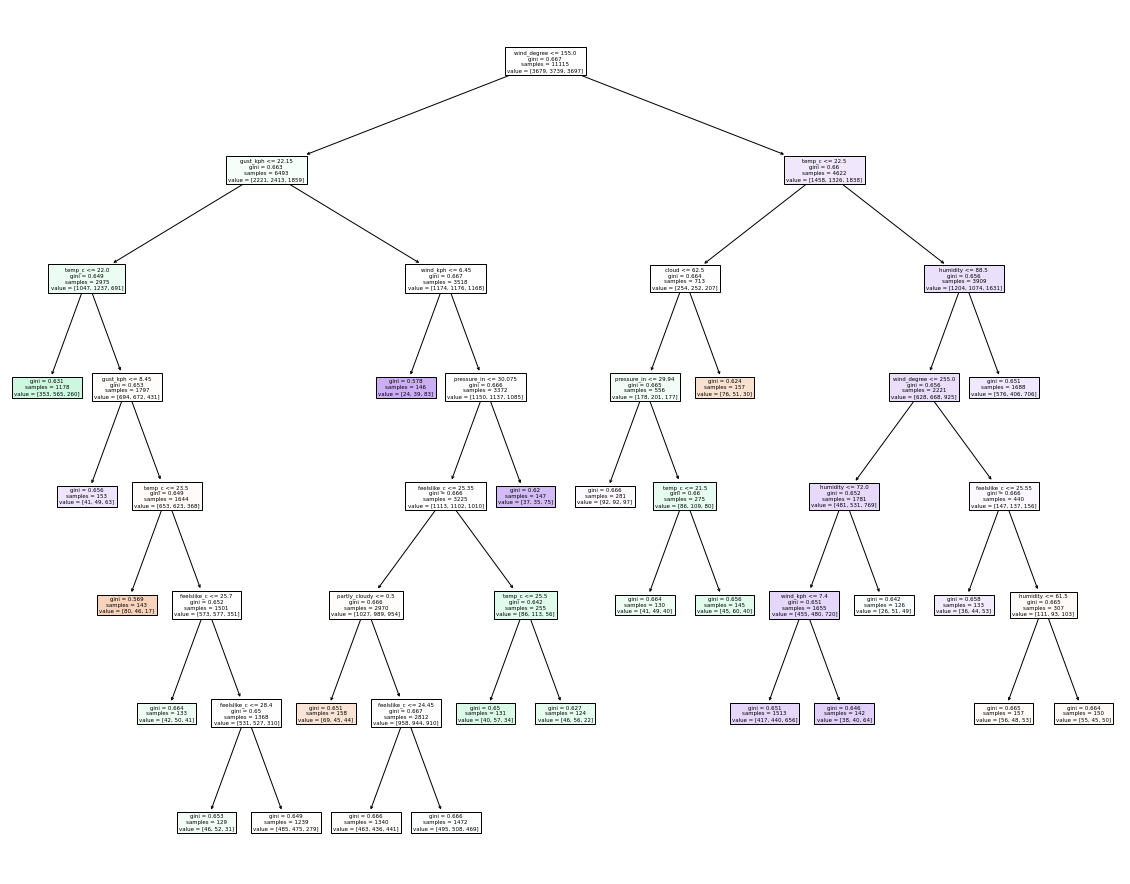

In [281]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# Assuming you have a dataframe called 'df' with your data
X = df_upsampled_blr[['temp_c', 'wind_kph', 'wind_degree', 'pressure_in', 'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'vis_km', 'uv', 'gust_kph', 'partly_cloudy', 'sunny', 'mist', 'clear' ]]
y = le.fit_transform(df_upsampled_blr['sentiment'])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
# print(y_test)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)

print(y_pred)
print(clf)
plt.figure(figsize=(20, 16))
tree.plot_tree(clf, feature_names=X.columns, filled=True)
plt.show()

In [280]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [5, 7, 9, 11],
    'min_samples_split': [5, 10, ],
    'min_samples_leaf': [2, 4],
}
X = df_upsampled_blr.drop(['tweet_id','tweet','sentiment','created_at', 'hashtags','username','location','retweet_count', 'org_tweet','org_lang','favorite_count','latitude', 'longitude','cleaned_tweet','currenttime','positive_prob','negative_prob','neutral_prob','place','date','time','date_time', 'current_date_time','wind_dir','conditions','created_at_edit'], axis=1)
y = le.fit_transform(df_upsampled_blr['sentiment'])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=687)

# Create the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Fit the classifier to the training data using the best hyperparameters
clf_best = grid_search.best_estimator_
clf_best.fit(X_train, y_train)

# Predict on the test set
y_pred = clf_best.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)

print(y_pred)

Best hyperparameters: {'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 5}
Accuracy: 0.39462636439966414
              precision    recall  f1-score   support

           0       0.38      0.33      0.35      1578
           1       0.37      0.39      0.38      1591
           2       0.43      0.47      0.45      1595

    accuracy                           0.39      4764
   macro avg       0.39      0.39      0.39      4764
weighted avg       0.39      0.39      0.39      4764

[1 0 2 ... 0 2 1]


## XGBOOST

Accuracy: 0.3866498740554156
              precision    recall  f1-score   support

           0       0.38      0.35      0.36      1608
           1       0.36      0.34      0.35      1554
           2       0.42      0.47      0.44      1602

    accuracy                           0.39      4764
   macro avg       0.38      0.39      0.38      4764
weighted avg       0.38      0.39      0.38      4764



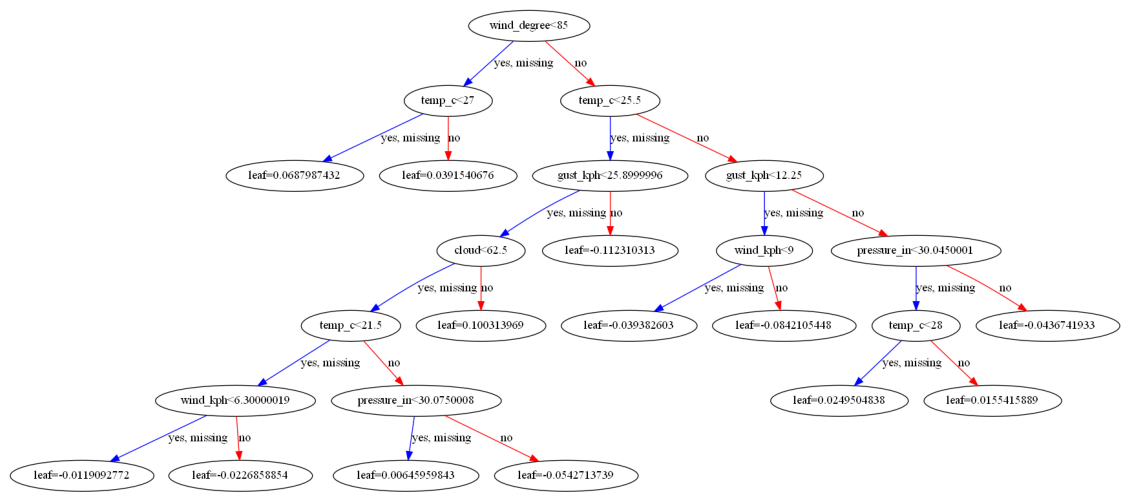

In [296]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

X = df_upsampled_blr[['temp_c', 'wind_kph', 'wind_degree', 'pressure_in', 'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'vis_km', 'uv', 'gust_kph', 'partly_cloudy', 'sunny', 'mist', 'clear' ]]
y = le.fit_transform(df_upsampled_blr['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the XGBoost model
xg_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=3)

# Train the model on the training data
xg_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)
fig, ax = plt.subplots(figsize=(20, 16))
xgb.plot_tree(xg_clf, num_trees=0, ax=ax)
plt.show()

In [239]:
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Assuming you have a dataframe called 'df' with your data
X = df_upsampled_blr.drop(['tweet_id','tweet','sentiment','created_at', 'hashtags','username','location','retweet_count', 'org_tweet','org_lang','favorite_count','latitude', 'longitude','cleaned_tweet','currenttime','positive_prob','negative_prob','neutral_prob','place','date','time','date_time', 'current_date_time','wind_dir','conditions','created_at_edit'], axis=1)
# X = df_upsampled_blr[['temp_c', 'wind_kph', 'wind_degree', 'pressure_in', 'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'vis_km', 'uv', 'gust_kph']]
y = le.fit_transform(df_upsampled_blr['sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'num_class': len(df_upsampled_blr['sentiment'].unique())
}

# Train the XGBoost model
xg = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the test set
y_pred = xg.predict(dtest)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)

print(y_pred)


Accuracy: 0.3866498740554156
              precision    recall  f1-score   support

           0       0.38      0.35      0.36      1608
           1       0.36      0.34      0.35      1554
           2       0.42      0.47      0.44      1602

    accuracy                           0.39      4764
   macro avg       0.38      0.39      0.38      4764
weighted avg       0.38      0.39      0.38      4764

[1. 1. 2. ... 0. 2. 1.]


## Random Forest

Accuracy: 0.3866498740554156
              precision    recall  f1-score   support

           0       0.38      0.35      0.36      1608
           1       0.36      0.34      0.35      1554
           2       0.42      0.47      0.44      1602

    accuracy                           0.39      4764
   macro avg       0.38      0.39      0.38      4764
weighted avg       0.38      0.39      0.38      4764



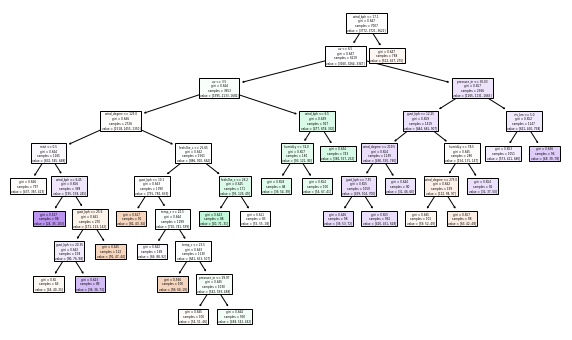

In [289]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Assuming you have a dataframe called 'df' with your data
X = df_upsampled_blr[['temp_c', 'wind_kph', 'wind_degree', 'pressure_in', 'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'vis_km', 'uv', 'gust_kph', 'partly_cloudy', 'sunny', 'mist', 'clear' ]]
# y = df_upsampled_blr['sentiment']
y = le.fit_transform(df_upsampled_blr['sentiment'])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the Random Forest Classifier
rfclf = RandomForestClassifier(n_estimators=100)

# Fit the classifier to the training data
rfclf.fit(X_train, y_train)

# Predict on the test set
y_pred = rfclf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)
# Choose an individual tree from the forest (e.g., the first tree)
tree_index = 0
tree_estimator = rfclf.estimators_[tree_index]

# Visualize the decision tree
plt.figure(figsize=(10, 6))
tree.plot_tree(tree_estimator, feature_names=X.columns, filled=True)
plt.show()

## Neural Nets

In [286]:
from keras.models import Sequential
from keras.layers import Dense

# Assuming you have a dataframe called 'df' with your data
X = df_upsampled_blr[['temp_c', 'wind_kph', 'wind_degree', 'pressure_in', 'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'vis_km', 'uv', 'gust_kph', 'partly_cloudy', 'sunny', 'mist', 'clear' ]]
y = le.fit_transform(df_upsampled_blr['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the neural network model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)


Epoch 1/50
348/348 [==============================] - 3s 5ms/step - loss: -1.0290 - accuracy: 0.3364
Epoch 2/50
348/348 [==============================] - 2s 6ms/step - loss: -3.4380 - accuracy: 0.3364
Epoch 3/50
348/348 [==============================] - 2s 5ms/step - loss: -8.6921 - accuracy: 0.3364
Epoch 4/50
348/348 [==============================] - 1s 4ms/step - loss: -19.1854 - accuracy: 0.3364
Epoch 5/50
348/348 [==============================] - 1s 3ms/step - loss: -36.5360 - accuracy: 0.3368
Epoch 6/50
348/348 [==============================] - 1s 4ms/step - loss: -62.9051 - accuracy: 0.3364
Epoch 7/50
348/348 [==============================] - 1s 3ms/step - loss: -100.0692 - accuracy: 0.3364
Epoch 8/50
348/348 [==============================] - 1s 3ms/step - loss: -143.6039 - accuracy: 0.3361
Epoch 9/50
348/348 [==============================] - 1s 3ms/step - loss: -202.8785 - accuracy: 0.3364
Epoch 10/50
348/348 [==============================] - 1s 3ms/step - loss: -270.53

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


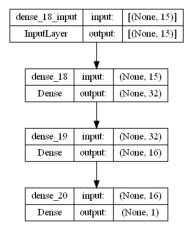

In [285]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='neural_network.png')

# Display the network architecture in the notebook
image = plt.imread('neural_network.png')
plt.imshow(image)
plt.axis('off')
plt.show()

## ENSEMBLE

In [241]:
from sklearn.ensemble import VotingClassifier

X = df_upsampled_blr.drop(['tweet_id','tweet','sentiment','created_at', 'hashtags','username','location','retweet_count', 'org_tweet','org_lang','favorite_count','latitude', 'longitude','cleaned_tweet','currenttime','positive_prob','negative_prob','neutral_prob','place','date','time','date_time', 'current_date_time','wind_dir','conditions','created_at_edit'], axis=1)
y = le.fit_transform(df_upsampled_blr['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the ensemble by combining the three models
ensemble = VotingClassifier(estimators=[
    ('decision_tree', clf),
#     ('xgboost', xg),
    ('random_forest', rfclf),
    ('xgboost2', xg_clf),
#     ('neuralnets',model)
], voting='hard')
ensemble._estimator_type = "classifier"

# Fit the ensemble model to the training data
ensemble.fit(X_train, y_train)

# Predict on the test set using the ensemble
y_pred_ensemble = ensemble.predict(X_test)

# Evaluate the accuracy of the ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print("Ensemble Accuracy:", accuracy_ensemble)

report_ensemble = classification_report(y_test, y_pred_ensemble)
print(report_ensemble)

Ensemble Accuracy: 0.3866498740554156
              precision    recall  f1-score   support

           0       0.38      0.35      0.36      1608
           1       0.36      0.34      0.35      1554
           2       0.42      0.47      0.44      1602

    accuracy                           0.39      4764
   macro avg       0.38      0.39      0.38      4764
weighted avg       0.38      0.39      0.38      4764



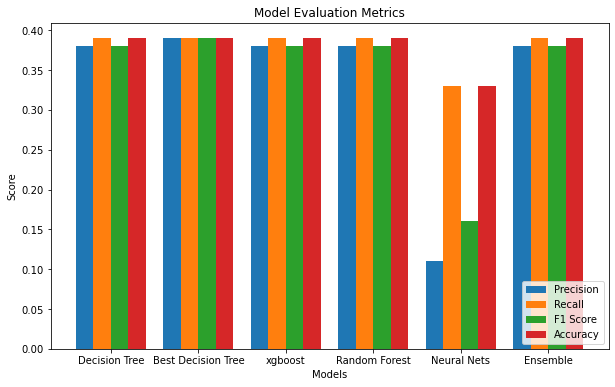

In [250]:
# Define the model names and evaluation metrics
model_names = ['Decision Tree', 'Best Decision Tree', 'xgboost', 'Random Forest', 'Neural Nets', 'Ensemble']
precision = [0.38,0.39, 0.38, 0.38, 0.11, 0.38]
recall = [0.39,0.39, 0.39, 0.39, 0.33, 0.39]
f1_score = [0.38,0.39, 0.38, 0.38, 0.16, 0.38]
accuracy = [0.39,0.39, 0.39, 0.39, 0.33, 0.39]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = range(len(model_names))
r2 = [x + bar_width for x in r1]
r3 = [x + 2 * bar_width for x in r1]
r4 = [x + 3 * bar_width for x in r1]

plt.figure(figsize=(10, 6))


# Create the bar chart
plt.bar(r1, precision, width=bar_width, label='Precision')
plt.bar(r2, recall, width=bar_width, label='Recall')
plt.bar(r3, f1_score, width=bar_width, label='F1 Score')
plt.bar(r4, accuracy, width=bar_width, label='Accuracy')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(loc ="lower right")
plt.title('Model Evaluation Metrics')
plt.xticks([r + 1.5 * bar_width for r in range(len(model_names))], model_names)

# Display the bar chart
plt.show()

# Predicting sentiment using weather details

## sanjose

In [79]:
weather = list(df_sanjose['conditions'].unique())
weather

['Partly cloudy', 'Overcast', 'Sunny', 'Clear']

In [70]:
grouped_df_sanjose_senti = df_sanjose.groupby(["sentiment","conditions"]).count().reset_index()

In [71]:
grouped_df_sanjose_senti

,sentiment,conditions,tweet_id,tweet,created_at,hashtags,username,location,retweet_count,org_tweet,...,wind_dir,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,created_at_edit
0,negative,Clear,41,41,41,41,41,41,41,41,...,41,41,41,41,41,41,41,41,41,41
1,negative,Overcast,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,89,89,89
2,negative,Partly cloudy,398,398,398,398,398,398,398,398,...,398,398,398,398,398,398,398,398,398,398
3,negative,Sunny,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
4,neutral,Clear,106,106,106,106,106,106,106,106,...,106,106,106,106,106,106,106,106,106,106
5,neutral,Overcast,236,236,236,236,236,236,236,236,...,236,236,236,236,236,236,236,236,236,236
6,neutral,Partly cloudy,1011,1011,1011,1011,1011,1011,1011,1011,...,1011,1011,1011,1011,1011,1011,1011,1011,1011,1011
7,neutral,Sunny,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65
8,positive,Clear,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40
9,positive,Overcast,75,75,75,75,75,75,75,75,...,75,75,75,75,75,75,75,75,75,75


### Upsampling

In [72]:
import pandas as pd
from sklearn.utils import resample

# Define the minority class label
majority_class = 'neutral'
majority_condition = 'Partly cloudy'

# Split the dataframe into minority and majority classes
majority_df = df_sanjose[df_sanjose['sentiment'] == majority_class]
minority_df = df_sanjose[df_sanjose['sentiment'] != majority_class]

# Upsample the minority class to the size of the majority class
upsampled_minority_df_sj_senti = resample(minority_df,
                                 replace=True,
                                 n_samples=len(majority_df)*2,
                                 random_state=42)

# Combine the upsampled minority class with the majority class
upsampled_df_sj_senti = pd.concat([upsampled_minority_df_sj_senti, majority_df])

# Shuffle the rows of the upsampled dataframe
upsampled_df_sj_senti = upsampled_df_sj_senti.sample(frac=1, random_state=42)

In [74]:
upsampled_df_sj_senti.groupby("sentiment").count()

,tweet_id,tweet,created_at,hashtags,username,location,retweet_count,org_tweet,org_lang,favorite_count,...,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,conditions,created_at_edit
sentiment,,,,,,,,,,,,,,,,,,,,,
negative,1473,1473,1473,1473,1473,1473,1473,1473,1473,1473,...,1473,1473,1473,1473,1473,1473,1473,1473,1473,1473
neutral,1418,1418,1418,1418,1418,1418,1418,1418,1418,1418,...,1418,1418,1418,1418,1418,1418,1418,1418,1418,1418
positive,1363,1363,1363,1363,1363,1363,1363,1363,1363,1363,...,1363,1363,1363,1363,1363,1363,1363,1363,1363,1363


In [75]:
upsampled_df_sj_senti.groupby(["sentiment","conditions"]).count().reset_index()

,sentiment,conditions,tweet_id,tweet,created_at,hashtags,username,location,retweet_count,org_tweet,...,wind_dir,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,created_at_edit
0,negative,Clear,130,130,130,130,130,130,130,130,...,130,130,130,130,130,130,130,130,130,130
1,negative,Overcast,249,249,249,249,249,249,249,249,...,249,249,249,249,249,249,249,249,249,249
2,negative,Partly cloudy,1048,1048,1048,1048,1048,1048,1048,1048,...,1048,1048,1048,1048,1048,1048,1048,1048,1048,1048
3,negative,Sunny,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
4,neutral,Clear,106,106,106,106,106,106,106,106,...,106,106,106,106,106,106,106,106,106,106
5,neutral,Overcast,236,236,236,236,236,236,236,236,...,236,236,236,236,236,236,236,236,236,236
6,neutral,Partly cloudy,1011,1011,1011,1011,1011,1011,1011,1011,...,1011,1011,1011,1011,1011,1011,1011,1011,1011,1011
7,neutral,Sunny,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65
8,positive,Clear,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120
9,positive,Overcast,182,182,182,182,182,182,182,182,...,182,182,182,182,182,182,182,182,182,182


In [81]:
import pandas as pd

# assuming your data frame is named "df"
minority_combinations = [
    ('positive', 'Sunny'),
    ('positive', 'Overcast'),
    ('positive', 'Clear'),
    ('negative', 'Sunny'),
    ('negative', 'Overcast'),
    ('negative', 'Clear'),
    ('neutral', 'Sunny'),
    ('neutral', 'Overcast'),
    ('neutral', 'Clear')
]

upsampled_dfs = []

for comb in minority_combinations:
#     print(comb)
    comb_df = upsampled_df_sj_senti[(upsampled_df_sj_senti['sentiment'] == comb[0]) & (upsampled_df_sj_senti['conditions'] == comb[1])]
#     print(comb_df)
    upsampled = comb_df.sample(n=1200, replace=True, random_state=42)
    upsampled_dfs.append(upsampled)

# concatenate all data frames
df_upsampled_sj = pd.concat([upsampled_df_sj_senti] + upsampled_dfs, ignore_index=True)
df_upsampled_sj#.columns#.groupby(["sentiment","conditions"]).count().reset_index()

,tweet_id,tweet,sentiment,created_at,hashtags,username,location,retweet_count,org_tweet,org_lang,...,pressure_in,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,conditions,created_at_edit
0,1656872935838322688,Is that good? https://t.co/u5BJ21Nr2F,positive,2023-05-12 04:04:25,,Patrick Dorn,"San Jose, CA",0,Is that good? https://t.co/u5BJ21Nr2F,en,...,30.04,0.0,75.0,25.0,15.2,16.0,1.0,9.7,Partly cloudy,2023-05-12 04:04:00
1,1643354889224065025,@EricTrump Me either from your corrupt family,negative,2023-04-04 20:48:32,,Holly Jafari 🌊🌊🌊🌊,"San Jose, CA",0,@EricTrump Me either from your corrupt family,en,...,30.24,0.0,37.0,25.0,12.0,16.0,4.0,11.5,Partly cloudy,2023-04-04 20:48:00
2,1649297362484092928,LIVE! Made it to Masters in Unite! more ranked...,positive,2023-04-21 06:21:48,"twitch, VTuberEN, PokemonUNITE, stream",☘️Vtuber | Gr33nme93☘️ (comms open 3/10),"San Jose, CA",0,LIVE! Made it to Masters in Unite! more ranked...,en,...,30.33,0.0,66.0,0.0,13.4,16.0,1.0,6.1,Clear,2023-04-21 06:21:00
3,1644170551618048002,"If you have $HEES or $URI in your portfolio, p...",neutral,2023-04-07 02:49:41,,Tickeron,"Sunnyvale, CA",0,"If you have $HEES or $URI in your portfolio, p...",en,...,30.05,0.0,55.0,100.0,14.7,16.0,1.0,1.4,Overcast,2023-04-07 02:49:00
4,1656873488244961280,@LaurenJauregui realest tweet of 2023,positive,2023-05-12 04:06:37,,₊‧°𐐪♡𐑂°‧₊,"San Jose, CA",0,@LaurenJauregui realest tweet of 2023,en,...,30.04,0.0,75.0,25.0,15.2,16.0,1.0,9.7,Partly cloudy,2023-05-12 04:06:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15049,1649297110305742849,Hong Kong Women While Studying in Japan While ...,neutral,2023-04-21 06:20:48,,s_adachi,"Silicon Valley, California",0,日本留学中の香港女性 戻った際 国家安全維持法違反疑いで逮捕 https://t.co/Qf...,ja,...,30.33,0.0,66.0,0.0,13.4,16.0,1.0,6.1,Clear,2023-04-21 06:20:00
15050,1649297828043427841,"If you have $BOIL or $COOK in your portfolio, ...",neutral,2023-04-21 06:23:39,,Tickeron,"Sunnyvale, CA",0,"If you have $BOIL or $COOK in your portfolio, ...",en,...,30.33,0.0,66.0,0.0,13.4,16.0,1.0,6.1,Clear,2023-04-21 06:23:00
15051,1649296632943616000,@TedNugent https://t.co/sU0Wt75Por,neutral,2023-04-21 06:18:54,,Brandon Moreno,"San Jose, CA",0,@TedNugent https://t.co/sU0Wt75Por,und,...,30.33,0.0,66.0,0.0,13.4,16.0,1.0,6.1,Clear,2023-04-21 06:18:00
15052,1649296852855193600,@RogersTina10 @FoxNews https://t.co/FRQaGf1wXd,neutral,2023-04-21 06:19:46,,Brandon Moreno,"San Jose, CA",0,@RogersTina10 @FoxNews https://t.co/FRQaGf1wXd,und,...,30.33,0.0,66.0,0.0,13.4,16.0,1.0,6.1,Clear,2023-04-21 06:19:00


In [82]:
from sklearn.preprocessing import OneHotEncoder

df_encoded = pd.get_dummies(df_upsampled_sj['conditions'])
df_encoded.columns = ['partly_cloudy', 'sunny', 'overcast', 'clear']

# Combine the one-hot encoded columns with the original dataframe
df_upsampled_sj = pd.concat([df_upsampled_sj, df_encoded], axis=1)
df_upsampled_sj

,tweet_id,tweet,sentiment,created_at,hashtags,username,location,retweet_count,org_tweet,org_lang,...,feelslike_c,vis_km,uv,gust_kph,conditions,created_at_edit,partly_cloudy,sunny,overcast,clear
0,1656872935838322688,Is that good? https://t.co/u5BJ21Nr2F,positive,2023-05-12 04:04:25,,Patrick Dorn,"San Jose, CA",0,Is that good? https://t.co/u5BJ21Nr2F,en,...,15.2,16.0,1.0,9.7,Partly cloudy,2023-05-12 04:04:00,0,0,1,0
1,1643354889224065025,@EricTrump Me either from your corrupt family,negative,2023-04-04 20:48:32,,Holly Jafari 🌊🌊🌊🌊,"San Jose, CA",0,@EricTrump Me either from your corrupt family,en,...,12.0,16.0,4.0,11.5,Partly cloudy,2023-04-04 20:48:00,0,0,1,0
2,1649297362484092928,LIVE! Made it to Masters in Unite! more ranked...,positive,2023-04-21 06:21:48,"twitch, VTuberEN, PokemonUNITE, stream",☘️Vtuber | Gr33nme93☘️ (comms open 3/10),"San Jose, CA",0,LIVE! Made it to Masters in Unite! more ranked...,en,...,13.4,16.0,1.0,6.1,Clear,2023-04-21 06:21:00,1,0,0,0
3,1644170551618048002,"If you have $HEES or $URI in your portfolio, p...",neutral,2023-04-07 02:49:41,,Tickeron,"Sunnyvale, CA",0,"If you have $HEES or $URI in your portfolio, p...",en,...,14.7,16.0,1.0,1.4,Overcast,2023-04-07 02:49:00,0,1,0,0
4,1656873488244961280,@LaurenJauregui realest tweet of 2023,positive,2023-05-12 04:06:37,,₊‧°𐐪♡𐑂°‧₊,"San Jose, CA",0,@LaurenJauregui realest tweet of 2023,en,...,15.2,16.0,1.0,9.7,Partly cloudy,2023-05-12 04:06:00,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15049,1649297110305742849,Hong Kong Women While Studying in Japan While ...,neutral,2023-04-21 06:20:48,,s_adachi,"Silicon Valley, California",0,日本留学中の香港女性 戻った際 国家安全維持法違反疑いで逮捕 https://t.co/Qf...,ja,...,13.4,16.0,1.0,6.1,Clear,2023-04-21 06:20:00,1,0,0,0
15050,1649297828043427841,"If you have $BOIL or $COOK in your portfolio, ...",neutral,2023-04-21 06:23:39,,Tickeron,"Sunnyvale, CA",0,"If you have $BOIL or $COOK in your portfolio, ...",en,...,13.4,16.0,1.0,6.1,Clear,2023-04-21 06:23:00,1,0,0,0
15051,1649296632943616000,@TedNugent https://t.co/sU0Wt75Por,neutral,2023-04-21 06:18:54,,Brandon Moreno,"San Jose, CA",0,@TedNugent https://t.co/sU0Wt75Por,und,...,13.4,16.0,1.0,6.1,Clear,2023-04-21 06:18:00,1,0,0,0
15052,1649296852855193600,@RogersTina10 @FoxNews https://t.co/FRQaGf1wXd,neutral,2023-04-21 06:19:46,,Brandon Moreno,"San Jose, CA",0,@RogersTina10 @FoxNews https://t.co/FRQaGf1wXd,und,...,13.4,16.0,1.0,6.1,Clear,2023-04-21 06:19:00,1,0,0,0


In [83]:
df_upsampled_sj.groupby(["sentiment","conditions"]).count().reset_index()

,sentiment,conditions,tweet_id,tweet,created_at,hashtags,username,location,retweet_count,org_tweet,...,cloud,feelslike_c,vis_km,uv,gust_kph,created_at_edit,partly_cloudy,sunny,overcast,clear
0,negative,Clear,1330,1330,1330,1330,1330,1330,1330,1330,...,1330,1330,1330,1330,1330,1330,1330,1330,1330,1330
1,negative,Overcast,1449,1449,1449,1449,1449,1449,1449,1449,...,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449
2,negative,Partly cloudy,1048,1048,1048,1048,1048,1048,1048,1048,...,1048,1048,1048,1048,1048,1048,1048,1048,1048,1048
3,negative,Sunny,1246,1246,1246,1246,1246,1246,1246,1246,...,1246,1246,1246,1246,1246,1246,1246,1246,1246,1246
4,neutral,Clear,1306,1306,1306,1306,1306,1306,1306,1306,...,1306,1306,1306,1306,1306,1306,1306,1306,1306,1306
5,neutral,Overcast,1436,1436,1436,1436,1436,1436,1436,1436,...,1436,1436,1436,1436,1436,1436,1436,1436,1436,1436
6,neutral,Partly cloudy,1011,1011,1011,1011,1011,1011,1011,1011,...,1011,1011,1011,1011,1011,1011,1011,1011,1011,1011
7,neutral,Sunny,1265,1265,1265,1265,1265,1265,1265,1265,...,1265,1265,1265,1265,1265,1265,1265,1265,1265,1265
8,positive,Clear,1320,1320,1320,1320,1320,1320,1320,1320,...,1320,1320,1320,1320,1320,1320,1320,1320,1320,1320
9,positive,Overcast,1382,1382,1382,1382,1382,1382,1382,1382,...,1382,1382,1382,1382,1382,1382,1382,1382,1382,1382


In [84]:
df_upsampled_sj.columns

Index(['tweet_id', 'tweet', 'sentiment', 'created_at', 'hashtags', 'username',
       'location', 'retweet_count', 'org_tweet', 'org_lang', 'favorite_count',
       'latitude', 'longitude', 'cleaned_tweet', 'currenttime',
       'positive_prob', 'negative_prob', 'neutral_prob', 'place', 'date',
       'time', 'date_time', 'current_date_time', 'temp_c', 'wind_kph',
       'wind_degree', 'wind_dir', 'pressure_in', 'precip_mm', 'humidity',
       'cloud', 'feelslike_c', 'vis_km', 'uv', 'gust_kph', 'conditions',
       'created_at_edit', 'partly_cloudy', 'sunny', 'overcast', 'clear'],
      dtype='object')

## Decision Tree

Accuracy: 0.36705778171352665
              precision    recall  f1-score   support

           0       0.39      0.36      0.38      1546
           1       0.34      0.45      0.39      1475
           2       0.39      0.29      0.33      1496

    accuracy                           0.37      4517
   macro avg       0.37      0.37      0.36      4517
weighted avg       0.37      0.37      0.36      4517

[1 2 1 ... 1 2 0]
DecisionTreeClassifier()
[1 2 1 ... 1 2 0]
DecisionTreeClassifier()


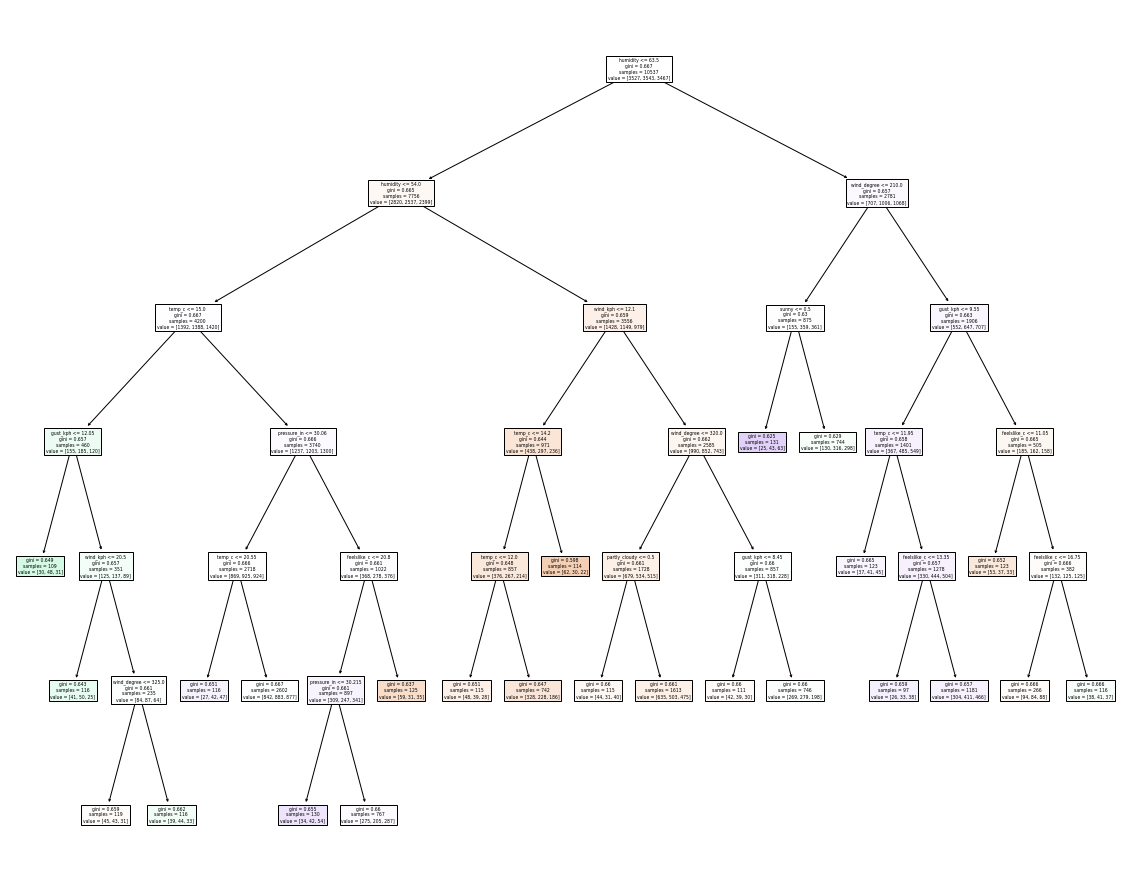

In [297]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# Assuming you have a dataframe called 'df' with your data
X = df_upsampled_sj[['temp_c', 'wind_kph', 'wind_degree', 'pressure_in', 'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'vis_km', 'uv', 'gust_kph', 'partly_cloudy', 'sunny', 'overcast', 'clear' ]]
y = le.fit_transform(df_upsampled_sj['sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
# print(y_test)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)

print(y_pred)
print(clf)
print(y_pred)
print(clf)
plt.figure(figsize=(20, 16))
tree.plot_tree(clf, feature_names=X.columns, filled=True)
plt.show()

In [221]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [5, 7, 9, 11],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
}
X = df_upsampled_sj.drop(['tweet_id','tweet','sentiment','created_at', 'hashtags','username','location','retweet_count', 'org_tweet','org_lang','favorite_count','latitude', 'longitude','cleaned_tweet','currenttime','positive_prob','negative_prob','neutral_prob','place','date','time','date_time', 'current_date_time','wind_dir','conditions','created_at_edit'], axis=1)
# X = df_upsampled_blr[['temp_c', 'wind_kph', 'wind_degree', 'pressure_in', 'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'vis_km', 'uv', 'gust_kph']]
y = le.fit_transform(df_upsampled_sj['sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=687)

# Create the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Fit the classifier to the training data using the best hyperparameters
clf_best = grid_search.best_estimator_
clf_best.fit(X_train, y_train)

# Predict on the test set
y_pred = clf_best.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)

print(y_pred)
print()

Best hyperparameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5}
Accuracy: 0.37104272747398714
              precision    recall  f1-score   support

           0       0.40      0.50      0.44      1514
           1       0.34      0.47      0.39      1473
           2       0.40      0.15      0.22      1530

    accuracy                           0.37      4517
   macro avg       0.38      0.37      0.35      4517
weighted avg       0.38      0.37      0.35      4517

[1 1 1 ... 1 0 0]



## XGBOOST

Accuracy: 0.36705778171352665
              precision    recall  f1-score   support

           0       0.39      0.36      0.38      1546
           1       0.34      0.45      0.39      1475
           2       0.39      0.29      0.33      1496

    accuracy                           0.37      4517
   macro avg       0.37      0.37      0.36      4517
weighted avg       0.37      0.37      0.36      4517



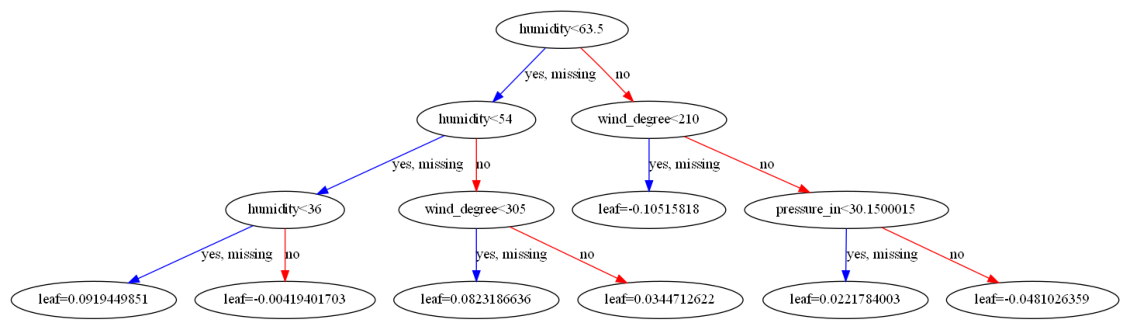

In [295]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Assuming you have a dataframe called 'df' with your data
X = df_upsampled_sj.drop(['tweet_id','tweet','sentiment','created_at', 'hashtags','username','location','retweet_count', 'org_tweet','org_lang','favorite_count','latitude', 'longitude','cleaned_tweet','currenttime','positive_prob','negative_prob','neutral_prob','place','date','time','date_time', 'current_date_time','wind_dir','conditions','created_at_edit'], axis=1)
y = le.fit_transform(df_upsampled_sj['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the XGBoost model
xg_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=3, max_depth=3)

# Train the model on the training data
xg_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)
fig, ax = plt.subplots(figsize=(20, 16))
xgb.plot_tree(xg_clf, num_trees=0, ax=ax)
plt.show()

In [216]:
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Assuming you have a dataframe called 'df' with your data
X = df_upsampled_sj.drop(['tweet_id','tweet','sentiment','created_at', 'hashtags','username','location','retweet_count', 'org_tweet','org_lang','favorite_count','latitude', 'longitude','cleaned_tweet','currenttime','positive_prob','negative_prob','neutral_prob','place','date','time','date_time', 'current_date_time','wind_dir','conditions','created_at_edit'], axis=1)
# X = df_upsampled_blr[['temp_c', 'wind_kph', 'wind_degree', 'pressure_in', 'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'vis_km', 'uv', 'gust_kph']]
y = le.fit_transform(df_upsampled_sj['sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'num_class': len(df_upsampled_sj['sentiment'].unique())
}

# Train the XGBoost model
xg = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the test set
y_pred = xg.predict(dtest)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)

print(y_pred)


Accuracy: 0.36705778171352665
              precision    recall  f1-score   support

           0       0.39      0.36      0.38      1546
           1       0.34      0.45      0.39      1475
           2       0.39      0.29      0.33      1496

    accuracy                           0.37      4517
   macro avg       0.37      0.37      0.36      4517
weighted avg       0.37      0.37      0.36      4517

[1. 2. 1. ... 1. 2. 0.]


## Random Forest

Accuracy: 0.3798981624972327
              precision    recall  f1-score   support

    negative       0.37      0.82      0.51      1546
     neutral       0.39      0.10      0.16      1475
    positive       0.40      0.20      0.26      1496

    accuracy                           0.38      4517
   macro avg       0.39      0.37      0.31      4517
weighted avg       0.39      0.38      0.32      4517



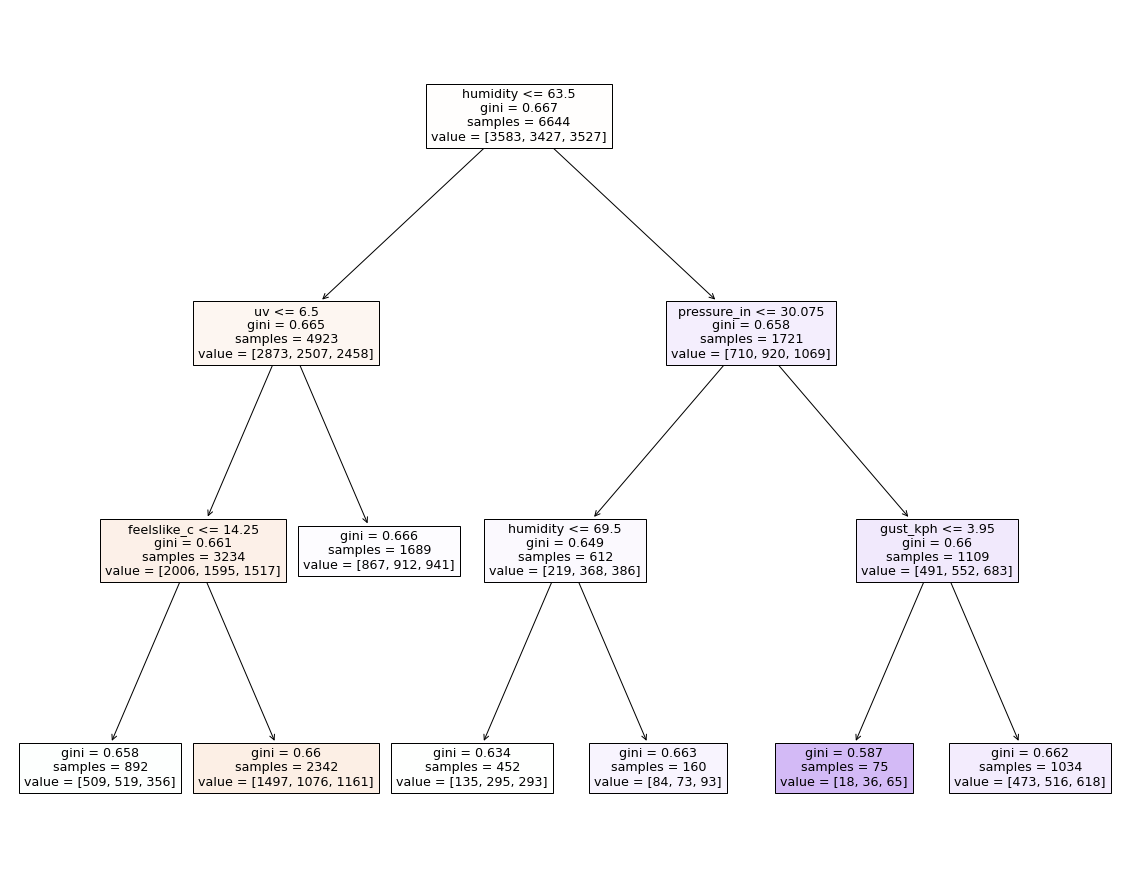

In [292]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Assuming you have a dataframe called 'df' with your data
X = df_upsampled_sj.drop(['tweet_id','tweet','sentiment','created_at', 'hashtags','username','location','retweet_count', 'org_tweet','org_lang','favorite_count','latitude', 'longitude','cleaned_tweet','currenttime','positive_prob','negative_prob','neutral_prob','place','date','time','date_time', 'current_date_time','wind_dir','conditions','created_at_edit'], axis=1)
y = df_upsampled_sj['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the Random Forest Classifier
rfclf = RandomForestClassifier(n_estimators=100,max_depth=3)

# Fit the classifier to the training data
rfclf.fit(X_train, y_train)

# Predict on the test set
y_pred = rfclf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)
# Choose an individual tree from the forest (e.g., the first tree)
tree_index = 0
tree_estimator = rfclf.estimators_[tree_index]

# Visualize the decision tree
plt.figure(figsize=(20, 16))
tree.plot_tree(tree_estimator, feature_names=X.columns, filled=True)
plt.show()

## Neural Networks

Epoch 1/50
330/330 [==============================] - 3s 4ms/step - loss: 0.4990 - accuracy: 0.3363
Epoch 2/50
330/330 [==============================] - 1s 4ms/step - loss: -2.0723 - accuracy: 0.3367
Epoch 3/50
330/330 [==============================] - 1s 3ms/step - loss: -6.5635 - accuracy: 0.3362
Epoch 4/50
330/330 [==============================] - 1s 4ms/step - loss: -15.2315 - accuracy: 0.3364
Epoch 5/50
330/330 [==============================] - 1s 3ms/step - loss: -31.6091 - accuracy: 0.3345
Epoch 6/50
330/330 [==============================] - 1s 4ms/step - loss: -58.9038 - accuracy: 0.3368
Epoch 7/50
330/330 [==============================] - 1s 4ms/step - loss: -98.3787 - accuracy: 0.3367
Epoch 8/50
330/330 [==============================] - 1s 3ms/step - loss: -153.8442 - accuracy: 0.3379
Epoch 9/50
330/330 [==============================] - 1s 3ms/step - loss: -226.2721 - accuracy: 0.3368
Epoch 10/50
330/330 [==============================] - 1s 4ms/step - loss: -316.1642

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


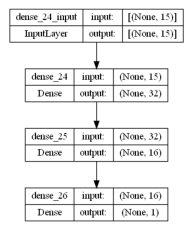

In [287]:
from keras.models import Sequential
from keras.layers import Dense

# Assuming you have a dataframe called 'df' with your data
X = df_upsampled_sj.drop(['tweet_id','tweet','sentiment','created_at', 'hashtags','username','location','retweet_count', 'org_tweet','org_lang','favorite_count','latitude', 'longitude','cleaned_tweet','currenttime','positive_prob','negative_prob','neutral_prob','place','date','time','date_time', 'current_date_time','wind_dir','conditions','created_at_edit'], axis=1)
y = le.fit_transform(df_upsampled_sj['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the neural network model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print(report)
plot_model(model, show_shapes=True, show_layer_names=True, to_file='neural_network.png')

# Display the network architecture in the notebook
image = plt.imread('neural_network.png')
plt.imshow(image)
plt.axis('off')
plt.show()

## ENSEMBLE

In [232]:
from sklearn.ensemble import VotingClassifier

# Assuming you have trained the three models and obtained the predictions
# y_pred_decision_tree, y_pred_xgboost, y_pred_random_forest
X = df_upsampled_sj.drop(['tweet_id','tweet','sentiment','created_at', 'hashtags','username','location','retweet_count', 'org_tweet','org_lang','favorite_count','latitude', 'longitude','cleaned_tweet','currenttime','positive_prob','negative_prob','neutral_prob','place','date','time','date_time', 'current_date_time','wind_dir','conditions','created_at_edit'], axis=1)
y = le.fit_transform(df_upsampled_sj['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the ensemble by combining the three models
ensemble = VotingClassifier(estimators=[
    ('decision_tree', clf),
#     ('xgboost', xg),
    ('random_forest', rfclf),
    ('xgboost2', xg_clf),
#     ('neuralnets',model)
], voting='hard')
ensemble._estimator_type = "classifier"

# Fit the ensemble model to the training data
ensemble.fit(X_train, y_train)

# Predict on the test set using the ensemble
y_pred_ensemble = ensemble.predict(X_test)

# Evaluate the accuracy of the ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print("Ensemble Accuracy:", accuracy_ensemble)

report_ensemble = classification_report(y_test, y_pred_ensemble)
print(report_ensemble)

Ensemble Accuracy: 0.36705778171352665
              precision    recall  f1-score   support

           0       0.39      0.36      0.38      1546
           1       0.34      0.45      0.39      1475
           2       0.39      0.29      0.33      1496

    accuracy                           0.37      4517
   macro avg       0.37      0.37      0.36      4517
weighted avg       0.37      0.37      0.36      4517



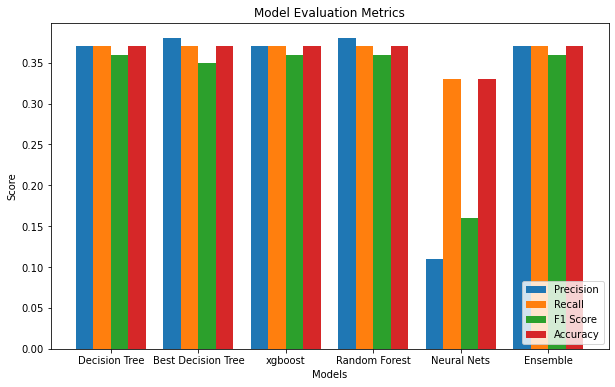

In [264]:
# Define the model names and evaluation metrics
model_names = ['Decision Tree', 'Best Decision Tree', 'xgboost', 'Random Forest', 'Neural Nets', 'Ensemble']
precision = [0.37,0.38, 0.37, 0.38, 0.11, 0.37]
recall = [0.37,0.37, 0.37, 0.37, 0.33, 0.37]
f1_score = [0.36,0.35, 0.36, 0.36, 0.16, 0.36]
accuracy = [0.37,0.37, 0.37, 0.37, 0.33, 0.37]



# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = range(len(model_names))
r2 = [x + bar_width for x in r1]
r3 = [x + 2 * bar_width for x in r1]
r4 = [x + 3 * bar_width for x in r1]

plt.figure(figsize=(10, 6))


# Create the bar chart
plt.bar(r1, precision, width=bar_width, label='Precision')
plt.bar(r2, recall, width=bar_width, label='Recall')
plt.bar(r3, f1_score, width=bar_width, label='F1 Score')
plt.bar(r4, accuracy, width=bar_width, label='Accuracy')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.xticks([r + 1.5 * bar_width for r in range(len(model_names))], model_names)
plt.legend(loc ="lower right")

# Display the bar chart
plt.show()

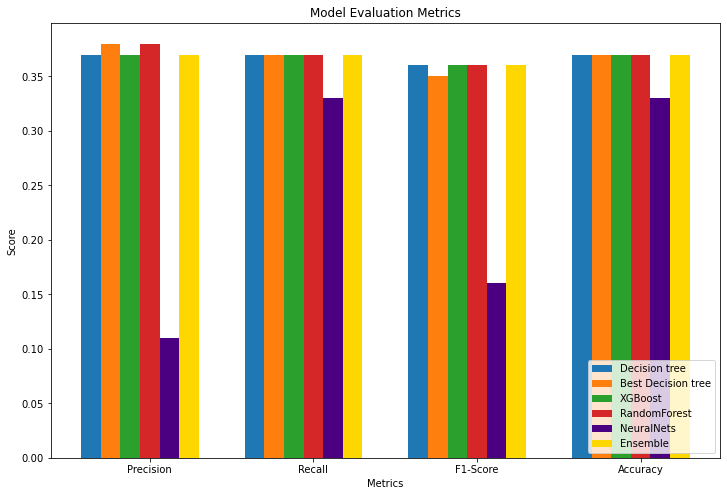

In [312]:
import matplotlib.pyplot as plt

# Define the model names and evaluation metrics
model_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
Decision_tree = [0.37, 0.37, 0.36, 0.37]
Best_Decision_tree = [0.38, 0.37, 0.35, 0.37]
XGBoost = [0.37, 0.37, 0.36, 0.37]
RandomForest = [0.38, 0.37, 0.36, 0.37]
NeuralNets = [0.11, 0.33, 0.16, 0.33]
Ensemble = [0.37, 0.37, 0.36, 0.37]

# Set the width of the bars
bar_width = 0.12

# Set the positions of the bars on the x-axis
r1 = range(len(model_names))
r2 = [x + bar_width for x in r1]
r3 = [x + 2 * bar_width for x in r1]
r4 = [x + 3 * bar_width for x in r1]
r5 = [x + 4 * bar_width for x in r1]
r6 = [x + 5 * bar_width for x in r1]
colors = ['blue', 'green', 'red','yellow','orange','maroon']
plt.figure(figsize=(12, 8))

# Create the bar chart
plt.bar(r1, Decision_tree, width=bar_width, label='Decision tree')
plt.bar(r2, Best_Decision_tree, width=bar_width, label='Best Decision tree')
plt.bar(r3, XGBoost, width=bar_width, label='XGBoost')
plt.bar(r4, RandomForest, width=bar_width, label='RandomForest')
plt.bar(r5, NeuralNets, width=bar_width, label='NeuralNets',color='Indigo')
plt.bar(r6, Ensemble, width=bar_width, label='Ensemble',color='gold')

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.xticks([r + 3 * bar_width for r in range(len(model_names))], model_names)
plt.legend(loc='lower right')

# Display the bar chart
plt.show()
